# Numerical Methods - Assignment 2

## 1. Gaussian Features
**Write a function that creates a set of evenly-spaced Gaussian functions.**

The input should be an vector $x$, a number of Gaussians $N$, and a fixed width $\sigma$.

In [1]:
import numpy as np

In [2]:
# Function to create a specified order Vandermonde matrix
def vandermonde(x, order):
    cols = []
    for i in range(order+1):
        cols.append(x**i)
    return np.hstack(cols)

In [3]:
def gaussian_features(x, N, sigma):
    x = x.reshape(-1) # reshape x back into a vector
    xk_vec = np.linspace(min(x), max(x), N)
    features = []
    for xk in xk_vec:
        features.append(np.exp(-(x - xk)**2 / (2*(sigma**2))))
    
    return np.array(features).T

**Use this function to plot 8 evenly-spaced Gaussians from -1 to 1 with a width of 0.2.**

You can randomly define the resolution of the range.

In [4]:
%matplotlib inline
import pylab as plt

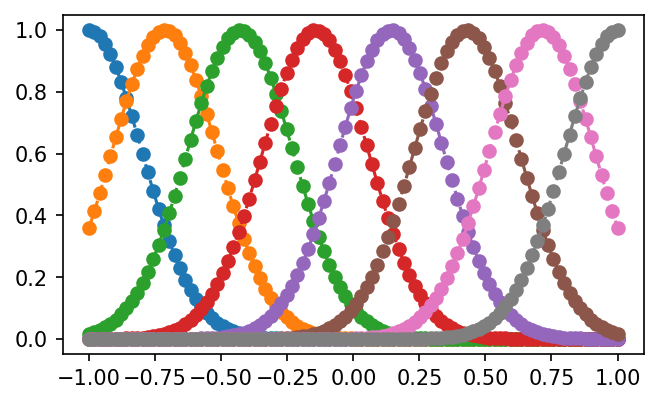

In [5]:
x = np.linspace(-1,1,100)

X_gauss = gaussian_features(x, 8, 0.2)
fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x, X_gauss[:,0], '--o')
ax.plot(x, X_gauss[:,1], '--o')
ax.plot(x, X_gauss[:,2], '--o')
ax.plot(x, X_gauss[:,3], '--o')
ax.plot(x, X_gauss[:,4], '--o')
ax.plot(x, X_gauss[:,5], '--o')
ax.plot(x, X_gauss[:,6], '--o')
ax.plot(x, X_gauss[:,7], '--o')

## 2. General Linear Regression
**Determine the best-fit of the peaks below using general linear regression.**

Plot the result of your regression model along with the original data.

You may assume that:
- The peaks follow a Gaussian distribution.
- There are 3 peaks of the **same width** in this region of the spectra below.

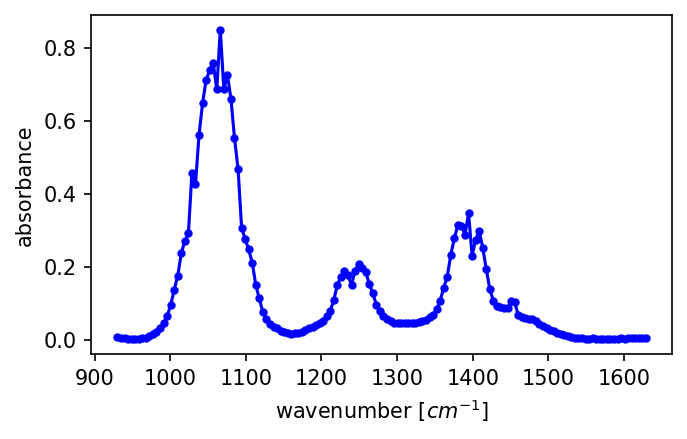

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[100:250]
y_peak = y_all[100:250]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

Weights from least-squares regression: [0.82362887 0.2039222  0.32350264]
SSE: 0.18628273989160957


Text(0, 0.5, 'absorbance')

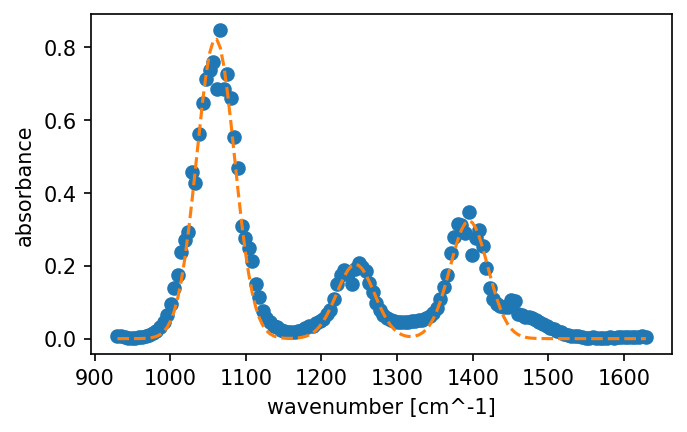

In [7]:
# Initial width guess: sigma = 25
# Three peaks: 1060, 1245, 1395
X_gauss = np.zeros((len(x_peak), 3))
X_gauss[:,0] = np.exp(-(x_peak-1060)**2 / (2*(25**2)))
X_gauss[:,1] = np.exp(-(x_peak-1245)**2 / (2*(25**2)))
X_gauss[:,2] = np.exp(-(x_peak-1395)**2 / (2*(25**2)))

A = X_gauss.T@X_gauss
b = X_gauss.T@y_peak
w_slr = np.linalg.solve(A, b)
print(f"Weights from least-squares regression: {w_slr}")

yhat = X_gauss@w_slr
SSE = sum((y_peak - yhat)**2)
print(f"SSE: {SSE}")

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, 'o')
ax.plot(x_peak, yhat, '--')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance')

**Briefly describe the result.**

**Initial sigma guess = 25**:  
**Initial peaks guesses = 1060, 1245, 1395**
 
**Overall:**  
The results of regression fit relatively well with the data. However, there are some slight deviation happening between the shoulder at the end and in between peak2 and peak3.

**Continue working on general linear regression.**

Now the second assumption is gone. You do not know how many peaks there are, or the widths of the peaks. However, you do know that they follow Gaussian distributions.

- Use your intuition and trial-and-error along to find a model that describes the data.
- Also plot the result along with the original data.
- This is not a spectroscopy class. There is no right answer to this question.

Weights from least-squares regression: [ 0.03702927 -0.06011669  0.08114038 -0.11386869  0.35199658  0.72151318
 -0.46670602  0.35897189 -0.27479947  0.2546581  -0.25746301  0.50737796
 -0.35894554  0.26997274 -0.10618672 -0.07484215  0.55986463 -0.37143681
  0.31745331 -0.17054618  0.13334944 -0.09327267  0.06624609 -0.04072604
  0.02426743]
SSE: 0.05800333947887354


Text(0, 0.5, 'absorbance')

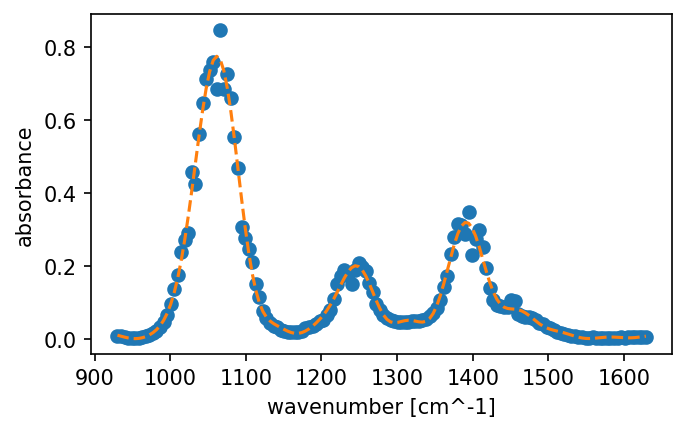

In [8]:
# Final width guess: sigma = 30
X_gauss = gaussian_features(x_peak, 25, 30)

A = X_gauss.T@X_gauss
b = X_gauss.T@y_peak
w_slr = np.linalg.solve(A, b)
print(f"Weights from least-squares regression: {w_slr}")

yhat = X_gauss@w_slr
SSE = sum((y_peak - yhat)**2)
print(f"SSE: {SSE}")

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, 'o')
ax.plot(x_peak, yhat, '--')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance')

## 3. Non-linear Regression

**Write a loss function.**

You want to solve the same problem above using non-linear regression to find the optimal positions and widths of the peaks.

The inputs of the loss function should be:
- a parameter vector $\vec{\lambda} = [ \vec{w}, \vec{\mu}, \vec{\sigma} ]$
- an input vector $x$
- an output vector $y$
- a number of Gaussians $n$

The function should return a root-mean-squared error of the estimation.

In [9]:
import numpy as np

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[100:250]
y_peak = y_all[100:250]

In [11]:
def gaussian_loss(lamda, x, y, m):
    yhat = np.zeros(len(y))
    for i in range(m):
        w_i = lamda[i]
        mu_i = lamda[m+i]
        sigma_i = lamda[2*m+i]
        yhat += w_i*np.exp(-(x - mu_i)**2 / (2*(sigma_i**2)))
    RMSE = np.sum((y - yhat)**2)/len(y)
    
    return RMSE

**Use `autograd` to compute the derivative of the loss function.**

Find the derivative of the loss function when all of the parameters are 1.

In [12]:
import autograd.numpy as np
from autograd import grad

def g(lamda, x=x_peak, y=y_peak, m=2):
    return gaussian_loss(lamda, x, y, m)

lamda = [1., 1., 1., 1., 1., 1.]
diff_g = grad(g)
print(g(lamda))
print(diff_g(lamda))
diff_g(lamda)

0.05320986
[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]


[array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]

**Implement gradient descent method.**

Write a function for an iteration of gradient descent that returns the optimal parameters.

The inputs are:
- a parameter vector $\vec{\lambda}$
- a function $g$
- a step size
- a tolerance

In [13]:
# from  scipy.optimize  import minimize
from scipy.optimize import minimize

In [14]:
def grad_descent(lamda, g, h, tol):
    count = 0
    loss = g(lamda)
    loss_percent = 1
    new_lamda = np.zeros(len(lamda))
    while(loss_percent >= tol):
        new_lamda = lamda - h*np.array(diff_g(lamda))
        loss_percent = (abs(g(lamda) - g(new_lamda))) / (g(lamda))
        lamda = new_lamda
        loss = g(lamda)
        count += 1

    print(f"Final Loss: {loss}, Iterations: {count}, Tolerance: {loss_percent}")
    return new_lamda

In [15]:
# Test Case: tol = 0.0005, h = 0.1, lamda = [1.0, 1.0, 1.0, 1000.0, 1250.0, 1500.0, 35.0, 30.0, 30.0]
def g(lamda, x=x_peak, y=y_peak, m=3):
    return gaussian_loss(lamda, x, y, m)

lamda = [1.0, 1.0, 1.0, 1100.0, 1250.0, 1400.0, 30.0, 30.0, 30.0]
new_lamda = grad_descent(lamda, g, 0.1, 0.0005)
new_lamda

Final Loss: 0.07010678647102307, Iterations: 21, Tolerance: 0.00046762375225828476


array([ 3.58469941e-01, -7.27617808e-02,  9.99626078e-01,  1.09999995e+03,
        1.24999962e+03,  1.39999999e+03,  3.00000000e+01,  3.00000000e+01,
        3.00000000e+01])

**Find the optimal parameters.**

Plot the result of non-linear regression along with the original data. Set the number of Gaussians as 5.

In [16]:
lamda = [0.8, 0.15, 0.4, 0.1, 0.1, 1060.0, 1250.0, 1400.0, 1.0, 1.0, 35.0, 30.0, 30.0, 1.0, 1.0]

n = 5
def g(lamda, x=x_peak, y=y_peak, m=n):
    return gaussian_loss(lamda, x, y, m)

new_lamda = grad_descent(lamda, g, 0.1, 0.00005)
new_lamda

Final Loss: 0.004513827376567893, Iterations: 125, Tolerance: 4.858969403932035e-05


array([8.00000000e-01, 2.96489070e-01, 4.00000000e-01, 1.00017978e-01,
       1.00000000e-01, 1.06000000e+03, 1.25000000e+03, 1.40000000e+03,
       1.00000000e+00, 1.00000000e+00, 3.50000000e+01, 3.00000000e+01,
       3.00000000e+01, 1.00000000e+00, 1.00000000e+00])

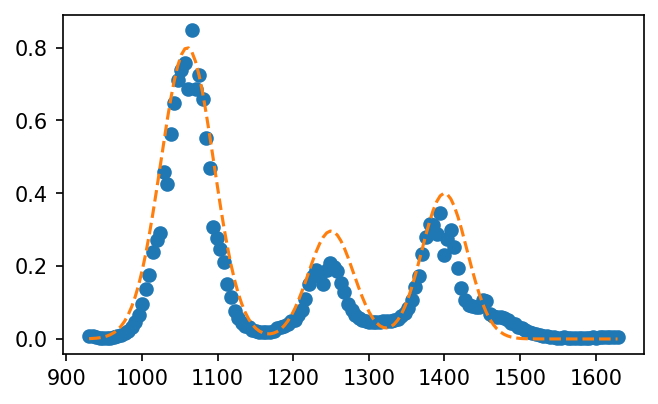

In [17]:
def n_gaussians(lamda, x, y, m):
    yhat = np.zeros(len(y))
    for i in range(m):
        w_i = lamda[i]
        mu_i = lamda[m+i]
        sigma_i = lamda[2*m+i]
        yhat += w_i*np.exp(-(x - mu_i)**2 / (2*(sigma_i**2)))
    return yhat
yhat = n_gaussians(new_lamda, x_peak, y_peak, 5)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.plot(x_peak, y_peak, 'o')
ax.plot(x_peak, yhat, '--')

**Print the weights $\vec{w}$.**

In [18]:
for i in range(5):
    print(f"w{i}: {new_lamda[i]}")

w0: 0.8
w1: 0.29648906999425667
w2: 0.4
w3: 0.1000179783408686
w4: 0.1


**Constrain the weights.**

Modify the loss function to constrain the weights to be positive. You can write this in code, or you can write an analytical version of the loss function.

In [19]:
def gaussian_loss(lamda, x, y, m):
    yhat = np.zeros(len(y))
    for i in range(m):
        w_i = lamda[i]
        if (abs(lamda[i]) - lamda[i]) != 0: # comparing the absolute of the weight parameters
            w_i = 0
        mu_i = lamda[m+i]
        sigma_i = lamda[2*m+i]
        yhat += w_i*np.exp(-(x - mu_i)**2 / (2*(sigma_i**2)))
    RMSE = np.sum((y - yhat)**2)/len(y)
    
    return RMSE

# Regression - Assignment 4

## Data and Package Import

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt

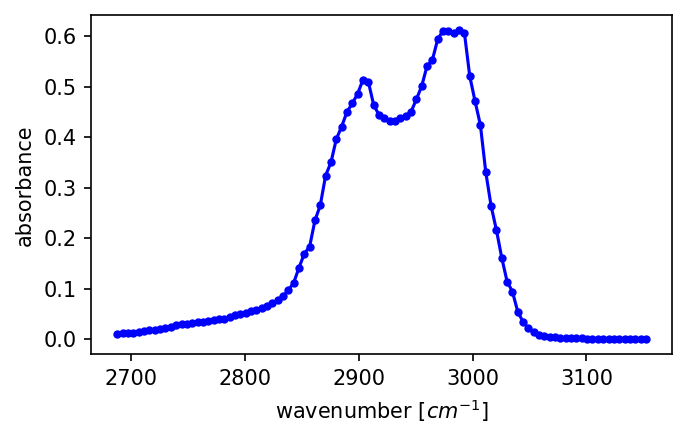

In [9]:
df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Mean Absolute Errors

**Write a function that computes the mean absolute error (MAE).**

In [10]:
def MAE(actual, prediction):
    z = zip(actual, prediction)
    N = len(actual)
    sum = 0
    for a,p in z:
        sum += abs(a - p)
    mae = sum / N
    
    return mae

**Use 8-fold cross-validation to compute the average and standard deviation of the MAE on the spectra dataset.**

Use a `LinearRegression` model and an `rbf` kernel with $\sigma$=100.

Make sure to pass `shuffle = True` argument when you make a `KFold` object.

In [11]:
def rbf(train, test=None, gamma=1):
    if test is None:
        test = train
    N = len(test)
    M = len(train)
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-gamma*(test[i] - train[j])**2)
    return X

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=8, shuffle=True)
sigma = 100
gamma = 1./2/sigma**2

mae_test = []
for train_index, test_index in kf.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    X_train = rbf(x_train, gamma=gamma)
    model_rbf = LinearRegression()
    model_rbf.fit(X_train, y_train)
    
    X_test = rbf(x_train, test=x_test, gamma=gamma)
    yhat_rbf = model_rbf.predict(X_test)
    
    mae = MAE(y_peak, yhat_rbf)
    mae_test.append(mae)
        
    
avg = np.average(mae_test)
std = np.std(mae_test)
print(f"MAE avg: {avg}")
print(f"MAE std: {std}")

MAE avg: 0.021904281675185776
MAE std: 0.005578086556753034


**Determine the optimum $\sigma$ that results in the lowest mean of MAE.**

Vary the width of an `rbf` kernel with $\sigma$ = [1, 10, 50, 100, 150].

In [13]:
sigmas = [1, 10, 50, 100, 150]

In [14]:
# fig, ax = plt.subplots(figsize=(5,3), dpi=150)
# ax.plot(x_peak, y_peak, 'o')

for sigma in sigmas:
    kf = KFold(n_splits=8)
    gamma = 1./2/sigma**2

    mae_test = []
    for train_index, test_index in kf.split(x_peak):
        x_train, x_test = x_peak[train_index], x_peak[test_index]
        y_train, y_test = y_peak[train_index], y_peak[test_index]

        X_train = rbf(x_train, gamma=gamma)
        model_rbf = LinearRegression()
        model_rbf.fit(X_train, y_train)

        X_test = rbf(x_train, test=x_test, gamma=gamma)
        yhat_rbf = model_rbf.predict(X_test)

        mae = MAE(y_peak, yhat_rbf)
        mae_test.append(mae)
        # ax.plot(x_test, yhat_rbf, '-')
        

    avg = np.average(mae_test)
    std = np.std(mae_test)
    print(f"sigma: {sigma} =>")
    print(f"MAE avg: {avg}, std {std}")

# ax.set_xlabel('wavenumber [cm$^-1$]')
# ax.set_ylabel('absorbance')
# ax.legend(['Original Data', 'Prediction'])

sigma: 1 =>
MAE avg: 0.02253602377539161, std 0.003789127348077029
sigma: 10 =>
MAE avg: 36.27137594456271, std 21.608336468290634
sigma: 50 =>
MAE avg: 18.116523548975614, std 44.972975913515064
sigma: 100 =>
MAE avg: 0.5073780081974033, std 1.0179939956814976
sigma: 150 =>
MAE avg: 0.5017426394947037, std 0.8590805842817563


**Ans:**  
 When **sigma = 1**, the mean of the MAE is the lowest, therefore the optimum $\sigma$

## 2. Hyperparameter Tuning

**Reshape `x_peak` and `y_peak` into 2D array.**

In [15]:
x_peak = x_peak.reshape(-1,1)
y_peak = y_peak.reshape(-1,1)
print(x_peak.shape)
print(y_peak.shape)

(100, 1)
(100, 1)


**Do train/test split with `test_size=0.3` for the spectra data.**

In [16]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.3)

**Use `for` loop to determine the optimum regularization strength $\alpha$ of a KRR model.**

Use an `rbf` kernel with $\sigma$=20.

Determine the optimum value of $\alpha$ out of [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1].

In [17]:
from sklearn.kernel_ridge import KernelRidge

In [18]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for alpha in alphas:
    sigma = 20
    gamma = 1./(2*sigma**2)
    
    KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
    x_peak.reshape(-1,1)
    y_peak.reshape(-1,1)
    KRR.fit(x_train, y_train)
    
    r2_test = KRR.score(x_test, y_test)
    print(f'alpha: {alpha} =>')
    print(f"r2 on the test set: {r2_test}")

alpha: 1e-05 =>
r2 on the test set: 0.9989992081566272
alpha: 0.0001 =>
r2 on the test set: 0.9989641515473138
alpha: 0.001 =>
r2 on the test set: 0.9990208060027866
alpha: 0.01 =>
r2 on the test set: 0.9991658286987627
alpha: 0.1 =>
r2 on the test set: 0.9992795387036337
alpha: 1 =>
r2 on the test set: 0.9790139344661478


**Ans:**  
 When **alpha = 0.1**, the r$^2$ score seems to be the closest to 1. Therefore, the optimum $\alpha$

## 3. GridSearchCV

**Import a LASSO model.**

In [19]:
from sklearn.linear_model import Lasso

**Shuffle the `x_peak` and `y_peak`.**

You can get a shuffled array when you run `x_shuffle, y_shuffle = shuffle(x, y)`.

The reason why we shuffle the data is that `GridSearchCV` does not have an option to shuffle the input data. Note that we automatically shuffled the data in the problem 1.

In [20]:
from sklearn.utils import shuffle
x_shuffle, y_shuffle = shuffle(x_peak, y_peak)

**Build a `GridSearchCV` model that optimizes the hyperparameters of a LASSO model for the spectra data.**

Search over $\alpha \in$ [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] and $\sigma \in$ [5, 10, 15, 20, 25, 30, 35, 40].

Use 3-fold cross-validation.

*Hint: You will need to use a `for` loop over $\sigma$ values. Unlike KRR, LASSO models do not take neither`gamma` nor `sigma` as a parameter. You have to make an `rbf` kernel manually and input it to a LASSO model.*

Obtain the optimum $\alpha$ and the best score for each $\sigma$ value. Use `GridSearchCV.best_score_` as accuracy metric.

In [21]:
from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

for sigma in sigmas:
    gamma = 1./(2*sigma**2)
    
    ranges = {'alpha': alphas}
    LASSO = Lasso(max_iter=150000)
    LASSO_search = GridSearchCV(LASSO, ranges, cv=3)
    LASSO_search.fit(rbf(x_shuffle, x_shuffle, gamma=gamma), y_shuffle)
    print(f"sigma: {sigma} =>")
    print(LASSO_search.best_estimator_, LASSO_search.best_score_)

sigma: 5 =>
Lasso(alpha=1e-05, max_iter=150000) 0.8644665493552727
sigma: 10 =>
Lasso(alpha=1e-05, max_iter=150000) 0.994854127235035
sigma: 15 =>
Lasso(alpha=1e-05, max_iter=150000) 0.9981412149109556
sigma: 20 =>
Lasso(alpha=1e-05, max_iter=150000) 0.998395726678084
sigma: 25 =>
Lasso(alpha=1e-05, max_iter=150000) 0.9983626505217749
sigma: 30 =>
Lasso(alpha=1e-05, max_iter=150000) 0.9982123733221663
sigma: 35 =>
Lasso(alpha=1e-05, max_iter=150000) 0.997961639676905
sigma: 40 =>
Lasso(alpha=1e-05, max_iter=150000) 0.9970608032420886


**What is the optimum $\sigma$ and $\alpha$?**

**Ans:**  
 According to the above results, the optimum combination is **$\sigma$ = 25** and **$\alpha$ = 1e-05** 

**Optional Task**

**Check what happens if the input data is not shuffled before the `GridSearchCV`.**

In [22]:
for sigma in sigmas:
    gamma = 1./(2*sigma**2)
    
    ranges = {'alpha': alphas}
    LASSO = Lasso(max_iter=150000)
    LASSO_search = GridSearchCV(LASSO, ranges, cv=3)
    LASSO_search.fit(rbf(x_peak, x_peak, gamma=gamma), y_peak)
    print(f"sigma: {sigma} =>")
    print(LASSO_search.best_estimator_, LASSO_search.best_score_)

sigma: 5 =>
Lasso(alpha=1e-05, max_iter=150000) -17.897952091845607
sigma: 10 =>
Lasso(alpha=1e-05, max_iter=150000) -7.539157479519765
sigma: 15 =>
Lasso(alpha=1e-05, max_iter=150000) -4.451504848275911
sigma: 20 =>
Lasso(alpha=1e-05, max_iter=150000) -2.1970773495412783
sigma: 25 =>
Lasso(alpha=1e-05, max_iter=150000) -0.6164029632234316
sigma: 30 =>
Lasso(alpha=1e-05, max_iter=150000) 0.03170538887939237
sigma: 35 =>
Lasso(alpha=1e-05, max_iter=150000) -0.024951391374762395
sigma: 40 =>
Lasso(alpha=0.001, max_iter=150000) -0.8807381348901216


## 4. Ensemble Kernel Ridge Regression

In this problem you will combine ideas from k-fold cross-validation and bootstrapping with KRR to create an **ensemble** of KRR models.

**Reshape `x_peak` and `y_peak` into 2D array.**

In [23]:
x_peak = x_peak.reshape(-1,1)
y_peak = y_peak.reshape(-1,1)
print(x_peak.shape)
print(y_peak.shape)

(100, 1)
(100, 1)


**Use 5-fold cross-validation with the spectra data to construct a series of 5 KRR models with a `rbf` kernel with $\gamma$=0.0005 and $\alpha$=0.01.**

Each model will be trained with 80% of the data, but the exact training points will vary each time so the models will also vary.

Get the predictions from the whole `x_peak`.

In [24]:
gamma = 0.0005
alpha = 0.01
KRR_1 = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR_2 = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR_3 = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR_4 = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR_5 = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRRs = [KRR_1, KRR_2, KRR_3, KRR_4, KRR_5]

In [25]:
np.random.seed(0)
for i in range(5):  
    x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.8)
    
    KRRs[i].fit(x_train, y_train)

**Plot the resulting ensemble of models along with the original data.**

The plot should consists of 6 different lines (1 from the original data and 5 from KRR models).

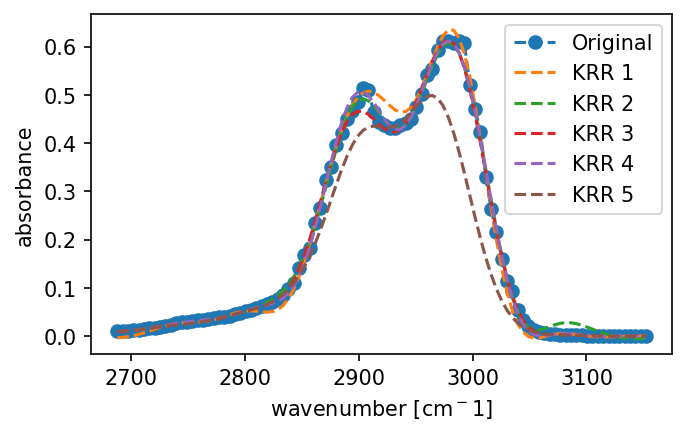

In [26]:
fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.plot(x_peak, y_peak, '--o')
index = 1

for KRR in KRRs:
    yhat_predict = KRR.predict(x_peak)
    
    ax.plot(x_peak, yhat_predict, '--')

ax.set_xlabel('wavenumber [cm$^-1$]')
ax.set_ylabel('absorbance')
ax.legend(['Original', 'KRR 1', 'KRR 2', 'KRR 3', 'KRR 4', 'KRR 5'])

**Plot the standard deviation of the 5 KRR models as a function of wavelength.**

In [27]:
stds = []
yhat1 = KRRs[0].predict(x_peak)
yhat2 = KRRs[1].predict(x_peak)
yhat3 = KRRs[2].predict(x_peak)
yhat4 = KRRs[3].predict(x_peak)
yhat5 = KRRs[4].predict(x_peak)

for i in range(len(y_peak)):
    yhats = [yhat1[i], yhat2[i], yhat3[i], yhat4[i], yhat5[i]]
    stds.append(np.std(yhats))

Text(0, 0.5, 'standard deviation')

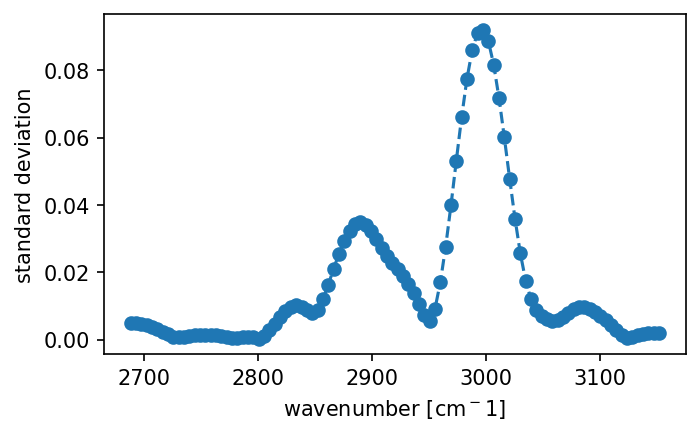

In [28]:
fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.plot(x_peak, stds, '--o')

ax.set_xlabel('wavenumber [cm$^-1$]')
ax.set_ylabel('standard deviation')

**Is the predicted error homoscedastic? Briefly explain.**

**Ans:**  
 The predicted error will not be homoscedastic, due to the obvious differences of variances accross wavenumbers. That is to say, the fluctuating standard deviation across the wavenumbers will lead to fluctuating variances. The size of the error term differs across values of an independent variable, in this case, the wavenumber.

# Classification - Assignment 6

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

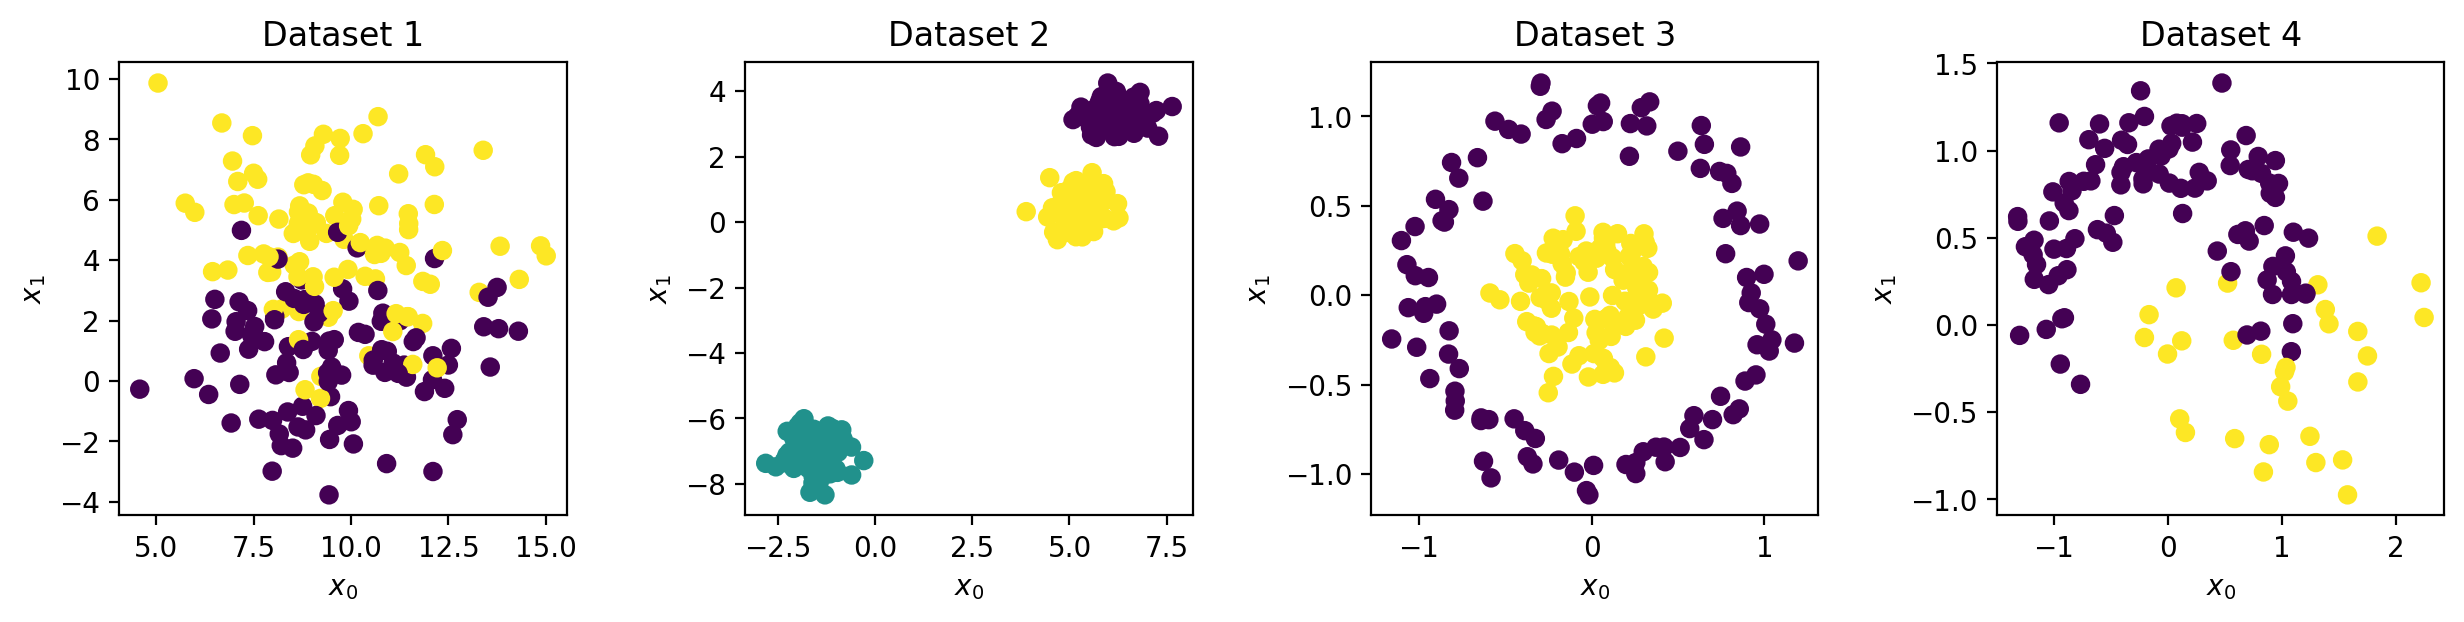

In [2]:
from sklearn.datasets import make_blobs, make_moons, make_circles
np.random.seed(4)

noisiness = 1

X_blob, y_blob = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

X_mc, y_mc = make_blobs(n_samples = 200, centers = 3, cluster_std = 0.5 * noisiness, n_features = 2)

X_circles, y_circles = make_circles(n_samples = 200, factor = 0.3, noise = 0.1 * noisiness)

X_moons, y_moons = make_moons(n_samples = 200, noise = 0.25 * noisiness)

N_include = 30
idxs = []
Ni = 0
for i, yi in enumerate(y_moons):
    if yi == 1 and Ni < N_include:
        idxs.append(i)
        Ni += 1
    elif yi == 0:
        idxs.append(i)

y_moons = y_moons[idxs]
X_moons = X_moons[idxs]

fig, axes = plt.subplots(1, 4, figsize = (15, 3), dpi = 200)

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]

labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:, 0], Xi[:, 1], c = yi)
    axes[i].set_title(labels[i])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')

fig.subplots_adjust(wspace = 0.4);

## 1. Discrimination Lines

**Derive the equation for the line that discriminates between the two classes.**

Consider a model of the form:

$\bar{\bar{X}}\vec{w} > 0$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} < 0$ if $y_i=-1$ (class 2)

where $\bar{\bar{X}} = [\vec{x_0}, \vec{x_1}, \vec{1}]$ and $\vec{w} = [w_0, w_1, w_2]$.

The equation should be in the form of $x_1 = f(x_0)$. Show your work, and/or explain the process you used to arrive at the answer.

**Ans:** 
 The equation will be
 
> $\bar{\bar{X}}\vec{w} = \vec{x_0}w_0 + \vec{x_1}w_1 + \vec{1}w_2 = 0$

> $x_1 = -\frac{w_0}{w_1}x_0 - \frac{w_2}{w_1}$

The slope will be $-\frac{w_0}{w_1}$ and the intercept will be $-\frac{w_2}{w_1}$

**Derive the discrimination line for a related non-linear model**

In this case, consider a model defined by:

$y_i = w_0 x_0 + w_1 x_1 + w_2 (x_0^2 + x_1^2)$

where the model predicts class 1 if $y_i > 0$ and predicts class 2 if $y_i \leq 0$.

The equation should be in the form of $x_1 = f(x_0)$. Show your work, and/or explain the process you used to arrive at the answer.

**Ans:** The equation will be 

> $w_0x_0 + w_1x_1 + w_2(x_0^2 + x_1^2)  =  0$

> $x_1^2 + \frac{w_1}{w_2}x_1  =  -\frac{w_0}{w_2}x_0 - x_0^2$

> $(x_1 + \frac{w_1}{2w_2})^2 + (x_0 + \frac{w_0}{2w_2})^2  =  (\frac{w_1}{2w_2})^2 + (\frac{w_0}{2w_2})^2$

> $x_1 = \sqrt{(-\frac{w_0}{w_2}x_0 - x_0^2 + (\frac{w_1}{2w_2})^2)} - (\frac{w_1}{2w_2})$

**Briefly describe the nature of this boundary.**

What is the shape of the boundary? Is it linear or non-linear?

**Ans:** According to

> $(x_1 + \frac{w_1}{2w_2})^2 + (x_0 + \frac{w_0}{2w_2})^2  =  (\frac{w_1}{2w_2})^2 - (\frac{w_0}{2w_2})^2$

The shape of boundary should be a circle. Therefore, it is non-linear

## 2. Assessing Loss Functions

In [3]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    X_intercept = np.append(intercept, X, 1)
    return X_intercept

In [4]:
def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return p > 0

**Write a function that computes the loss function for the perceptron model.**

The function should take the followings as arguments:
- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$

You may want to use functions above.

In [5]:
def perceptron(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    loss = sum(np.maximum(0, -y*Xb))
    return loss

**Write a function that computes the loss function for the logistic regression model.**

The function should take the followings as arguments:
- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$

You may want to use functions above.

In [6]:
def log_reg(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    loss = sum(np.log(1 + exp_yXb))
    return loss

**Minimize the both loss functions using the Dataset 3 above.**

In [25]:
from scipy.optimize import minimize
w = np.array([-9, -4, -9])

X = X_circles
y = y_circles * 2 - 1

result_perceptron = minimize(perceptron, w, args = (X, y))
result_logistic = minimize(log_reg, w, args = (X, y))

**What is the value of the loss function for the perceptron model after optimization?**

In [26]:
print(f'Perceptron loss function: {perceptron(result_perceptron.x, X, y)}')

Perceptron loss function: 7.43592526079778e-09


**What is the value of the loss function for the logistic regression model after optimization?**

In [27]:
print(f'Logistic regression loss function: {log_reg(result_logistic.x, X, y)}')

Logistic regression loss function: 138.60070170524114


**What are the two main challenges of the perceptron loss function?**

**Ans:**  
 1. The perceptron loss function has a trivial solution at $\vec{w}$ = 0
 2. The perceptron loss function is not differentiable

## 3. Support Vector Machine

**Write a function that computes the loss function of the support vector machine model.**

This functions should take the followings as arguments:

- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$
- regularization strength $\alpha$

You may want to use `add_intercept` and `linear_classifier` functions from the Problem 2.

In [10]:
def svm(w, X, y, alpha=1):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    loss = sum(np.maximum(0, 1 - y*Xb))
    loss += alpha*np.linalg.norm(w[1:], 2)
    return loss

**Evaluate the effect of regularization strength.**

Optimize the SVM model for **Dataset 1**.

Search over $\alpha$ = [0, 1, 2, 10, 100] and assess the loss function of the SVM model.

In [11]:
from scipy.optimize import minimize

X = X_blob
y = y_blob*2 - 1
w_guess = np.array([-10, -4, -10])

alphas = np.array([0, 1, 2, 10, 100])
results = []

for alpha in alphas:
    result = minimize(svm, w_guess, args=(X,y,alpha))
    results.append(result)
    print(svm(w_guess, X, y, alpha))

9627.260031082556
9638.030360696825
9648.800690311095
9734.963327225247
10704.292992509458


**Plot the discrimination lines for $\alpha$ = [0, 1, 2, 10, 100].**

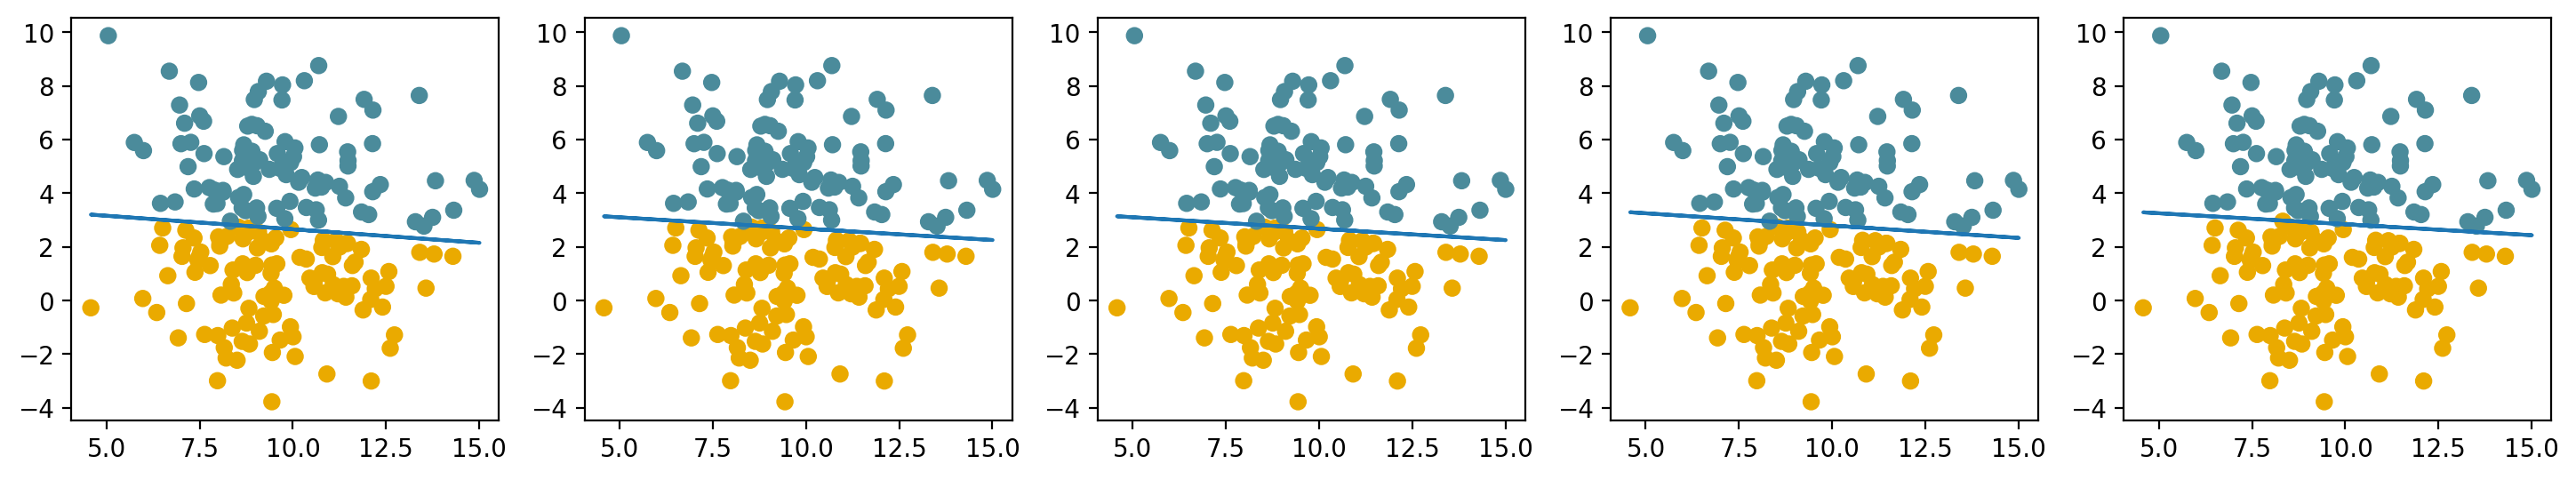

In [12]:
fig, axes = plt.subplots(1, 5, figsize = (18, 3), dpi = 200)

for i, result in enumerate(results):
    w_svm = result.x
    prediction = linear_classifier(X, w_svm)
    
    axes[i].scatter(X[:,0], X[:, 1], c=clrs[prediction + 1])
    m = -w_svm[1] / w_svm[2]
    b = -w_svm[0] / w_svm[2]
    axes[i].plot(X[:, 0], m*X[:, 0] + b, ls = '-')

**Find the optimal set of hyperparameters for an SVM model with Dataset 1.**

Use `GridSearchCV` and find the optimal value of $\alpha$ and $\gamma$.

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])
gammas = 1./(2*sigmas**2)
alphas = np.array([1, 2, 10, 100])
Cs = 1./alphas
parameter_ranges = {'C': Cs, 'gamma':gammas}

svc = SVC(kernel = 'rbf')
SVC_search = GridSearchCV(svc, parameter_ranges)
SVC_search.fit(X, y_blob)
print(f"Optimal Alpha: {1./SVC_search.best_estimator_.C}")
print(f"Optimal gamma: {SVC_search.best_estimator_.gamma}")
print(f"r2 Best Score: {SVC_search.best_score_}")

Optimal Alpha: 2.0
Optimal gamma: 0.0005555555555555556
r2 Best Score: 0.8699999999999999


**Calculate the accruacy, precision, and recall for the best model.**

You can write your own function that calculates the metrics or you may use built-in functions.

In [14]:
def acc_prec_recall(y_model, y_actual):
    TP = np.sum(np.logical_and(y_model == y_actual, y_model == 1))
    TN = np.sum(np.logical_and(y_model == y_actual, y_model == 0))
    FP = np.sum(np.logical_and(y_model != y_actual, y_model == 1))
    FN = np.sum(np.logical_and(y_model != y_actual, y_model == 0))
    acc = (TP + TN) / (TP + TN + FP + FN)
    if TP == 0:
        prec = 0
        recall = 0
    else:
        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
    return acc, prec, recall

In [15]:
from sklearn.metrics import confusion_matrix

svc_model = SVC(kernel='rbf', gamma=SVC_search.best_estimator_.gamma, C=SVC_search.best_estimator_.C)
svc_model.fit(X_blob, y_blob)
y_model = svc_model.predict(X_blob)

acc, prec, recall = acc_prec_recall(y_model, y_blob)
print(f"From acc_prec_recall function => accuracy: {acc} precision: {prec} recall: {recall}")

From acc_prec_recall function => accuracy: 0.86 precision: 0.8829787234042553 recall: 0.83


**Plot the confusion matrix.**

[[89 11]
 [17 83]]


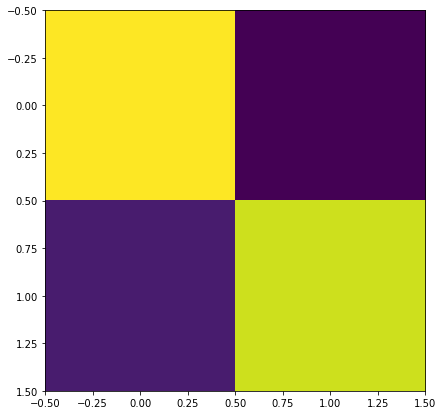

In [16]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_blob, y_model)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(conf_mat, cmap = 'viridis');
print(conf_mat)

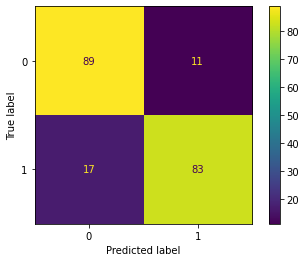

In [18]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svc_model, X_blob, y_blob)

**What happens to the decision boundary as $\alpha$ goes to $\infty$?**

**Ans:**  
 When $\alpha$ goes to $\infty$, C goes to 0. It will also mean that the regulization strength is high, resulting in large margins

**What happens to the decision boundary as $\gamma$ goes to 0?**

**Ans:**  
 When $\gamma$ goes to 0, it will result in wide rbf kernel

## 4. 6745 Only: Analytical Derivation

**Derive an analytical expression for the gradient of the softmax function with respect to $\vec{w}$.**

The **softmax** loss function is defined as:

$g(\vec{w}) = \sum_i log(1 + \exp{(-y_i \vec{x}_i^T \vec{w}}))$

where $\vec{x}_i$ is the $i$-th row of the input matrix $\bar{\bar{X}}$.

*Hint 1: The function $g(\vec{w})$ can be expressed as $f(r(s(\vec{w})))$ where $r$ and $s$ are arbitrary functions and the chain rule can be applied.*

*Hint 2: You may want to review Ch. 4 of "Machine Learning Refined, 1st Ed."*

> $g(\vec{w}) = \sum_i log(1 + \exp{(-y_i \vec{x}_i^T \vec{w}}))$

> $\sigma(-t) = \frac{1}{1 + e^t}$, $-t = -y_i \vec{x}_i^T \vec{w}$ 

> $\nabla{g(\vec{w})} = -\sum_i\sigma(-y_i \vec{x}_i^T \vec{w})y_i \vec{x}_i$

> $\nabla{}^2{g(\vec{w})} = -\sum_i\sigma(-y_i \vec{x}_i^T \vec{w})(1-\sigma( -y_i \vec{x}_i^T \vec{w}))\vec{x}_i\vec{x}_i^T$

**Optional: Logistic regression from the regression perspective**

An alternate interpretation of classification is that we are performing non-linear regression to fit a **step function** to our data (because the output is whether 0 or 1). Since step functions are not differentiable at the step, a smooth approximation with non-zero derivatives must be used. One such approximation is the *tanh* function:

$\tanh{(x)} = \frac{2}{1 + \exp{(-x)}} - 1$

This leads to a reformulation of the classification problem as:

$\vec{y} = \tanh{(\bar{\bar{X}}\vec{w})}$

Show that this is mathematically equivalent to **logistic regression**, or minimization of the **softmax** cost function.

# Regression - Assignment 5

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt

In [2]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X = np.array(all_data[real_rows, :-5], dtype = 'float')
y = np.array(all_data[real_rows, -3], dtype = 'float')
y = y.reshape(-1, 1)

print('X matrix dimensions: {}'.format(X.shape))
print('y matrix dimensions: {}'.format(y.shape))

X matrix dimensions: (10297, 40)
y matrix dimensions: (10297, 1)


## 1. Distribution of Features

**Plot the histograms of all 40 features.**

In [3]:
x_names = [str(x) for x in df.columns[1:41]]

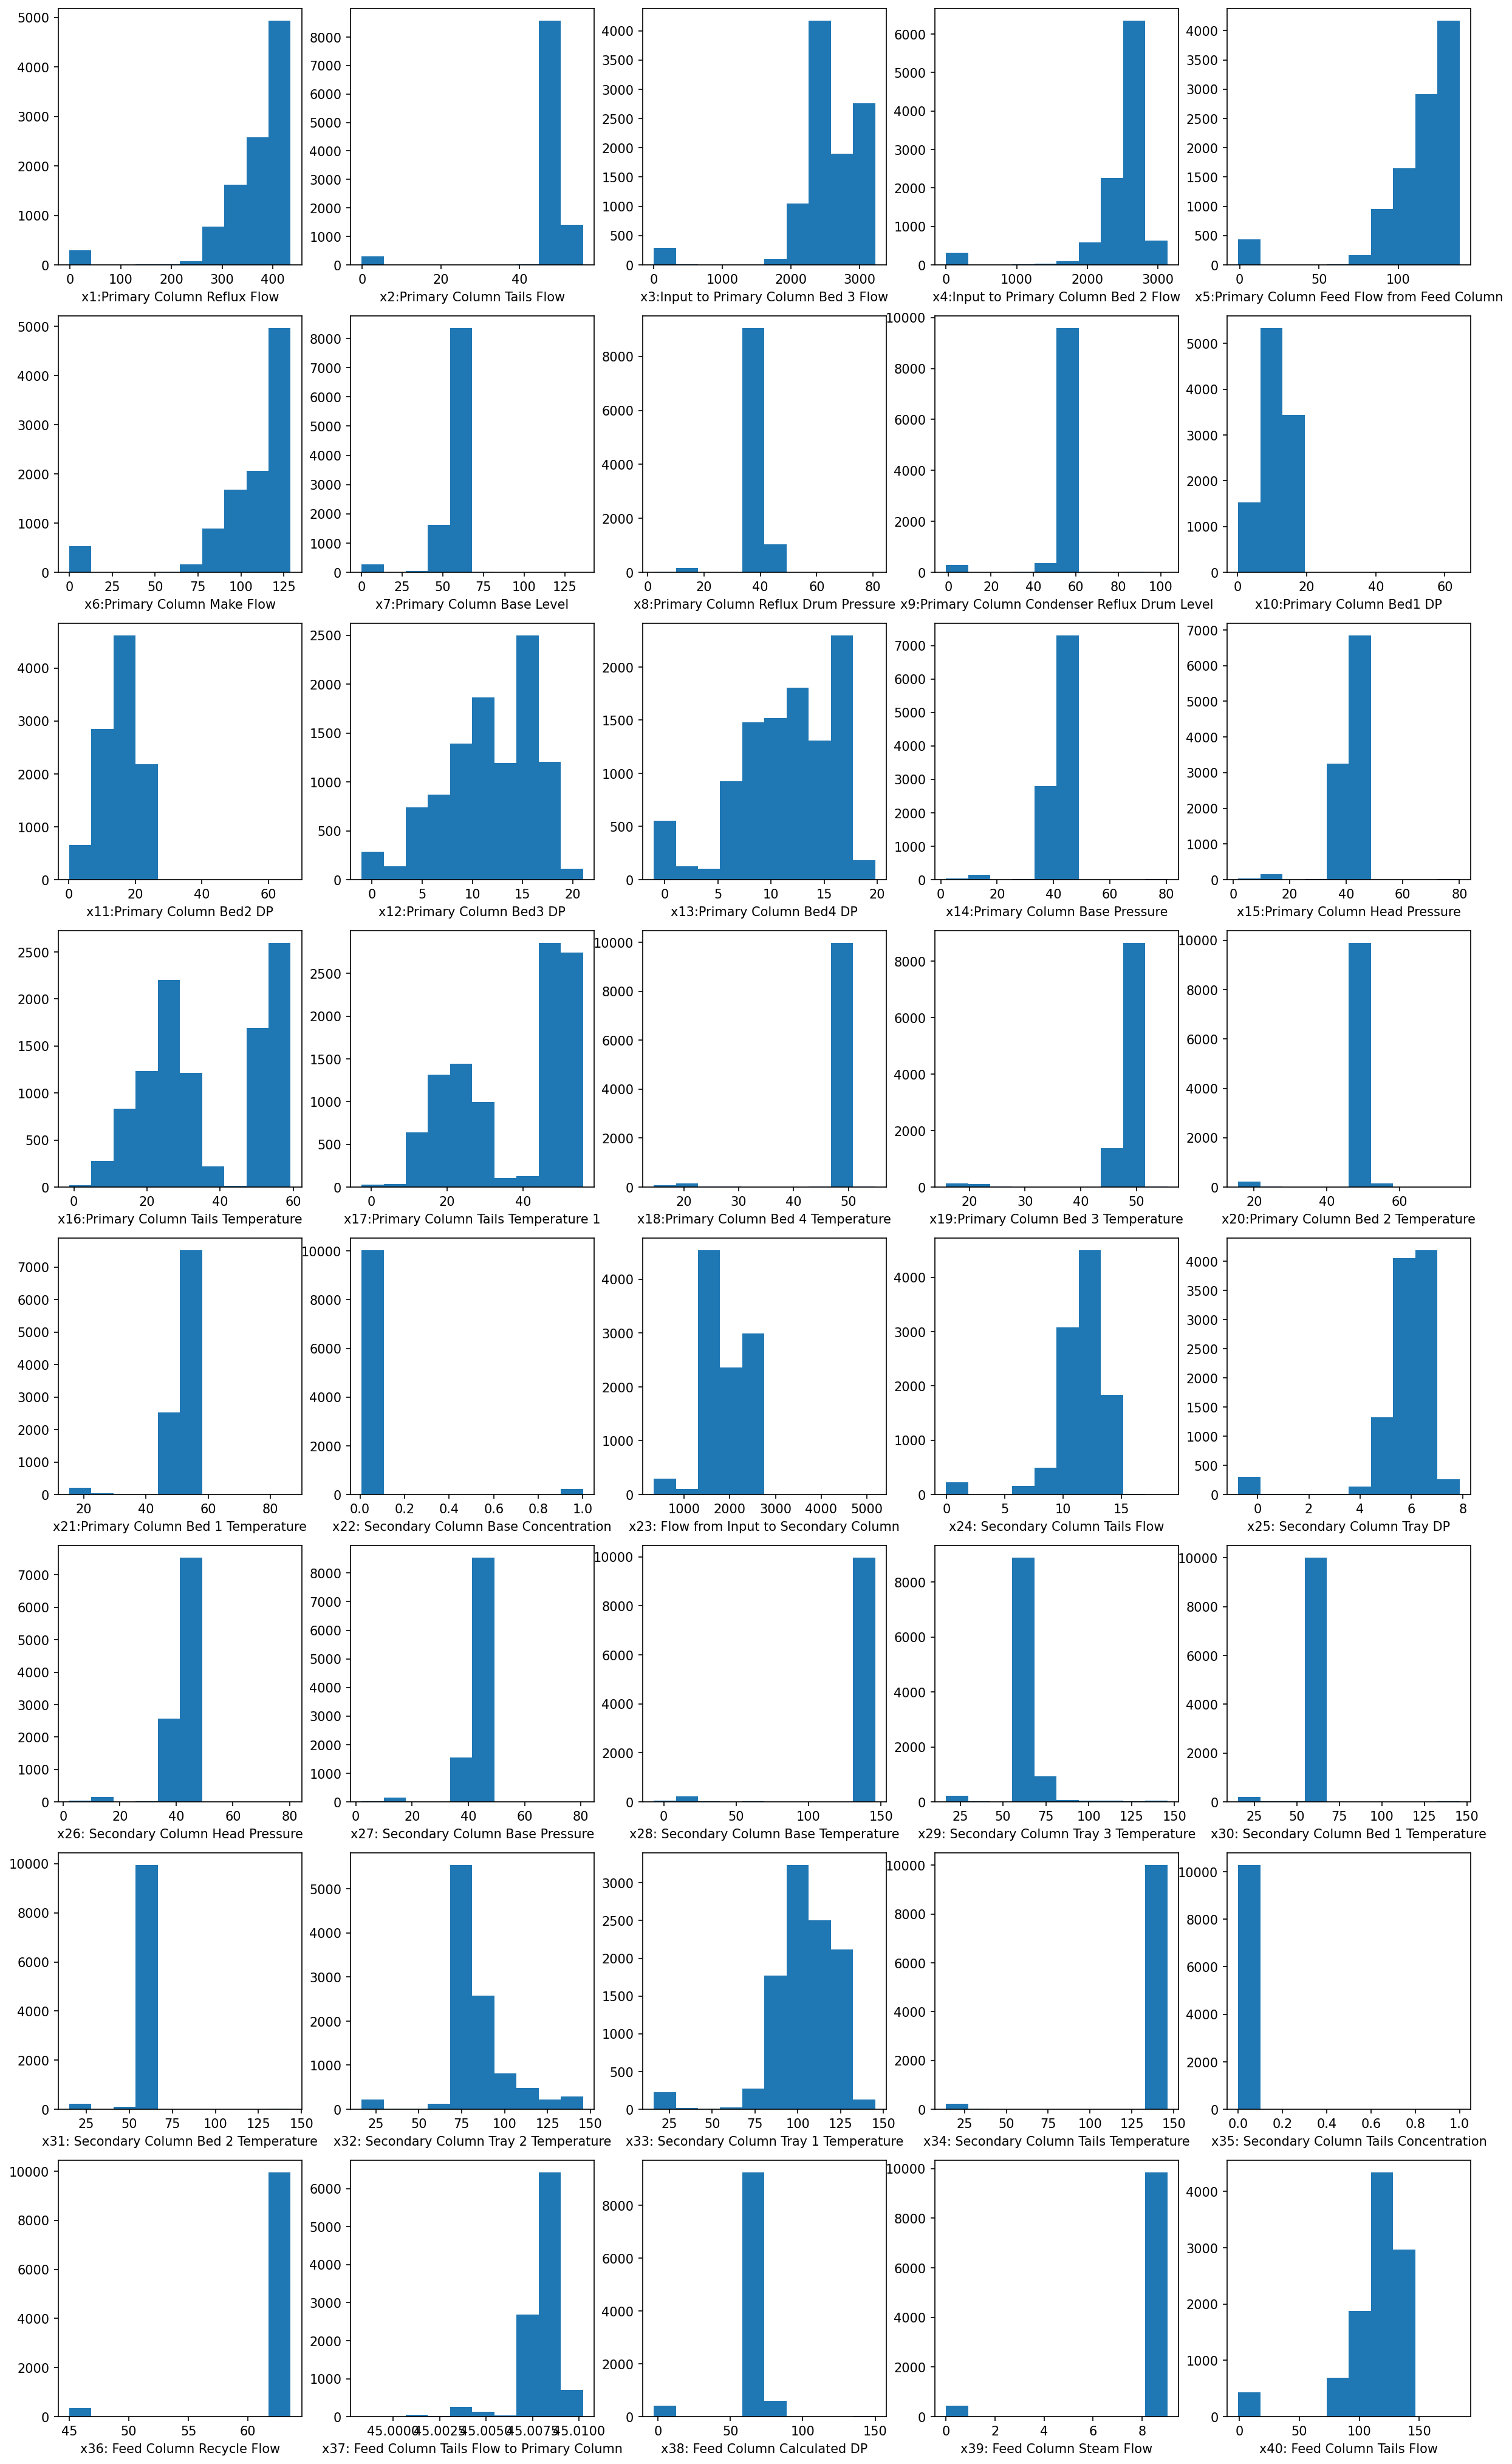

In [4]:
fig, axes = plt.subplots(8, 5, figsize = (20, 35), dpi = 150)
ax_list = axes.ravel()
for i in range(X.shape[-1]):
    ax_list[i].hist(X[:,i])
    ax_list[i].set_xlabel(x_names[i])

**Determine a feature that is roughly normally distributed.**

**Ans:**  
 For **feature number 12**, Bed3 DP, the histogram of this feature is roughly normally distributed

**Determine a feature that is bimodally distributed.**

**Ans:**  
 For **feature number 16 and 17**, Tails Temperature and Tails Temperature 1, seems to show bimodally distributed histogram.

**Determine a feature that has significant outliers.**

**Ans:**  
 For **feature number 40**, Feed Column Tails Flow, there seems to be significant outlier showing in the histogram.

## 2. Feature Scaling

**Down-sample the dataset by selecting every 10th data point.**

In [5]:
X_every10 = X[::10]
y_every10 = y[::10]
print(f"X dimension: {X_every10.shape}, y dimension: {y_every10.shape}")

X dimension: (1030, 40), y dimension: (1030, 1)


**Do train/test split with `test_size=0.3`.**

In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(X_every10, y_every10, test_size=0.3)

**Use the standard scaler and make the standardized dataset.**

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_scaled = scaler.transform(X_train)
print(f"X_scaled dimension: {X_scaled.shape}")
X_scaled

X_scaled dimension: (721, 40)


array([[-0.78148561,  0.24428681,  1.0249492 , ...,  0.30132514,
         0.2232524 , -0.84537209],
       [-4.62931526, -5.3378627 , -4.41129185, ..., -4.43960794,
        -4.42662381, -4.11795319],
       [ 0.54414273,  0.24765349,  1.20467989, ...,  0.33291854,
         0.22289959,  0.55702002],
       ...,
       [ 0.04695224,  0.16373189,  0.67745705, ...,  0.41039897,
         0.22493094,  0.14232031],
       [ 0.29708719,  0.12994253,  0.13476523, ...,  0.15883114,
         0.22734717,  0.45322784],
       [ 0.24353613,  0.23514551,  1.18665607, ...,  0.11145066,
         0.23004673,  0.30960718]])

**Build a KRR model on the Dow dataset with and without scaling.**

Set $\gamma$=0.01 and $\alpha$=0.01.

In [8]:
from sklearn.kernel_ridge import KernelRidge
gamma = 0.01
alpha = 0.01

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR.fit(X_train, y_train)
r2_train = KRR.score(X_train, y_train)

KRR_scaled = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR_scaled.fit(X_scaled, y_train)
r2_train_scaled = KRR_scaled.score(X_scaled, y_train)

print(f"training set score without scaling: {r2_train}")
print(f"training set score with scaling: {r2_train_scaled}")

training set score without scaling: 0.9993614827618904
training set score with scaling: 0.908451752339764


**Compare the $r^2$ score on the test set of the two approaches.**

In [9]:
r2_test = KRR.score(X_test, y_test)

X_test_scaled = scaler.transform(X_test)
r2_test_scaled = KRR_scaled.score(X_test_scaled, y_test)

print(f"testing set score without scaling: {r2_test}")
print(f"testing set score with scaling: {r2_test_scaled}")

testing set score without scaling: -5.96113188040398
testing set score with scaling: 0.6694722008306278


## 3. LASSO Regression

**Scale the feature matrix using the standard scaler.**

In [10]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
print(f"X_scaled dimension: {X_scaled.shape}")
X_scaled

X_scaled dimension: (10297, 40)


array([[-0.47531228, -0.26975732, -0.76421228, ...,  0.01286657,
         0.20686913, -0.48600418],
       [-0.53933239, -0.22513603, -0.75381485, ...,  0.00550393,
         0.2173227 , -0.48959728],
       [-0.58290255, -0.24570282, -0.75038405, ..., -0.02703654,
         0.20941823, -0.47542715],
       ...,
       [ 0.42731442,  0.09531506, -0.41178493, ...,  0.35542861,
         0.38225434,  0.40640929],
       [ 0.37626225,  0.12041229, -0.42717103, ...,  0.37095128,
         0.38637427,  0.41365434],
       [ 0.42451197,  0.12041229, -0.40152754, ...,  0.25366073,
         0.38641899,  0.38246753]])

**Shuffle the data.**

In [13]:
from sklearn.utils import shuffle

X_scaled_shuffle, y_shuffle = shuffle(X_scaled, y)

**Build a `GridSearchCV` model that optimizes the hyperparameters of a LASSO model.**

Search over $\alpha \in$ [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1].

Use 3-fold cross-validation.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
parameter_ranges = {'alpha': alphas}

LASSO = Lasso(max_iter=150000)
LASSO_search = GridSearchCV(LASSO, parameter_ranges, cv=3)
LASSO_search.fit(X_scaled_shuffle, y_shuffle)

GridSearchCV(cv=3, estimator=Lasso(max_iter=150000),
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])})

**Evaluate the performance of the best model.**

Print the optimized $\alpha$ as well as the $r^2$ score.

In [14]:
print(LASSO_search.best_estimator_, LASSO_search.best_score_)

Lasso(alpha=0.0001, max_iter=150000) 0.698877210102992


**Describe which features (if any) were dropped.**

Dropped features have coefficients equal to zero.

In [29]:
LASSO_best = Lasso(alpha=0.0001, max_iter=150000)
LASSO_best.fit(X_scaled_shuffle, y_shuffle)
coeffs = LASSO_best.coef_
nonzero = [f for f in np.isclose(coeffs,0) if f==False]

print(f"Original number of parameters: {len(coeffs)}")
print(f"(Current) Number of non-zero parameters: {len(nonzero)}\n")
print(np.isclose(coeffs,0))
print(
"""
Feature number 27 were dropped: Base Pressure
""")

Original number of parameters: 40
(Current) Number of non-zero parameters: 39

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False]

Feature number 27 were dropped: Base Pressure



## 4. Principal Component and Forward Selection

**Apply PCA to the scaled feature matrix.**

In [32]:
from scipy.linalg import eigvals, eig

covar = np.cov(X_scaled.T)
eigvals, eigvecs = eig(covar)

In [39]:
from sklearn.linear_model import LinearRegression
PCvals, PCvecs = eigvals, eigvecs

PC_projection = np.dot(X_scaled, PCvecs)

**Determine which principal component of the dataset is most linearly correlated with the impurity concentration.**

Print the order of the principal component (e.g. 5th PC) and its $r^2$ score.

In [42]:
score_list = []
for j in range(PC_projection.shape[1]):
    model = LinearRegression() #create a linear regression model instance
    xj = PC_projection[:,j].reshape(-1, 1)
    model.fit(xj, y) #fit the model
    r2 = model.score(xj, y) #get the "score", which is equivalent to r^2
    score_list.append([r2, j])
score_list.sort()
score_list.reverse()

print(f"{score_list[0][1]+1}th PC with r2 = {score_list[0][0]}")
print("is most linearly correlated to impurity concentration")

2th PC with r2 = 0.20685135722275416
is most linearly correlated to impurity concentration


**Determine which original feature of the dataset is most linearly correlated to the impurity concentration.**

Print the name of the feature and its $r^2$ score.

In [45]:
score_list = []
for j in range(X_scaled.shape[1]):
    model = LinearRegression() #create a linear regression model instance
    xj = X_scaled[:,j].reshape(-1, 1)
    model.fit(xj, y) #fit the model
    r2 = model.score(xj, y) #get the "score", which is equivalent to r^2
    score_list.append([r2, j])
score_list.sort()
score_list.reverse()

print(f"{score_list[0][1]+1}th feature: {x_names[score_list[0][1]]}")
print(f"r2 = {score_list[0][0]}")
print("is most linearly correlated to impurity concentration")

10th feature: x10:Primary Column Bed1 DP
r2 = 0.490256121705657
is most linearly correlated to impurity concentration


# Classification - Assignment 6

## Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

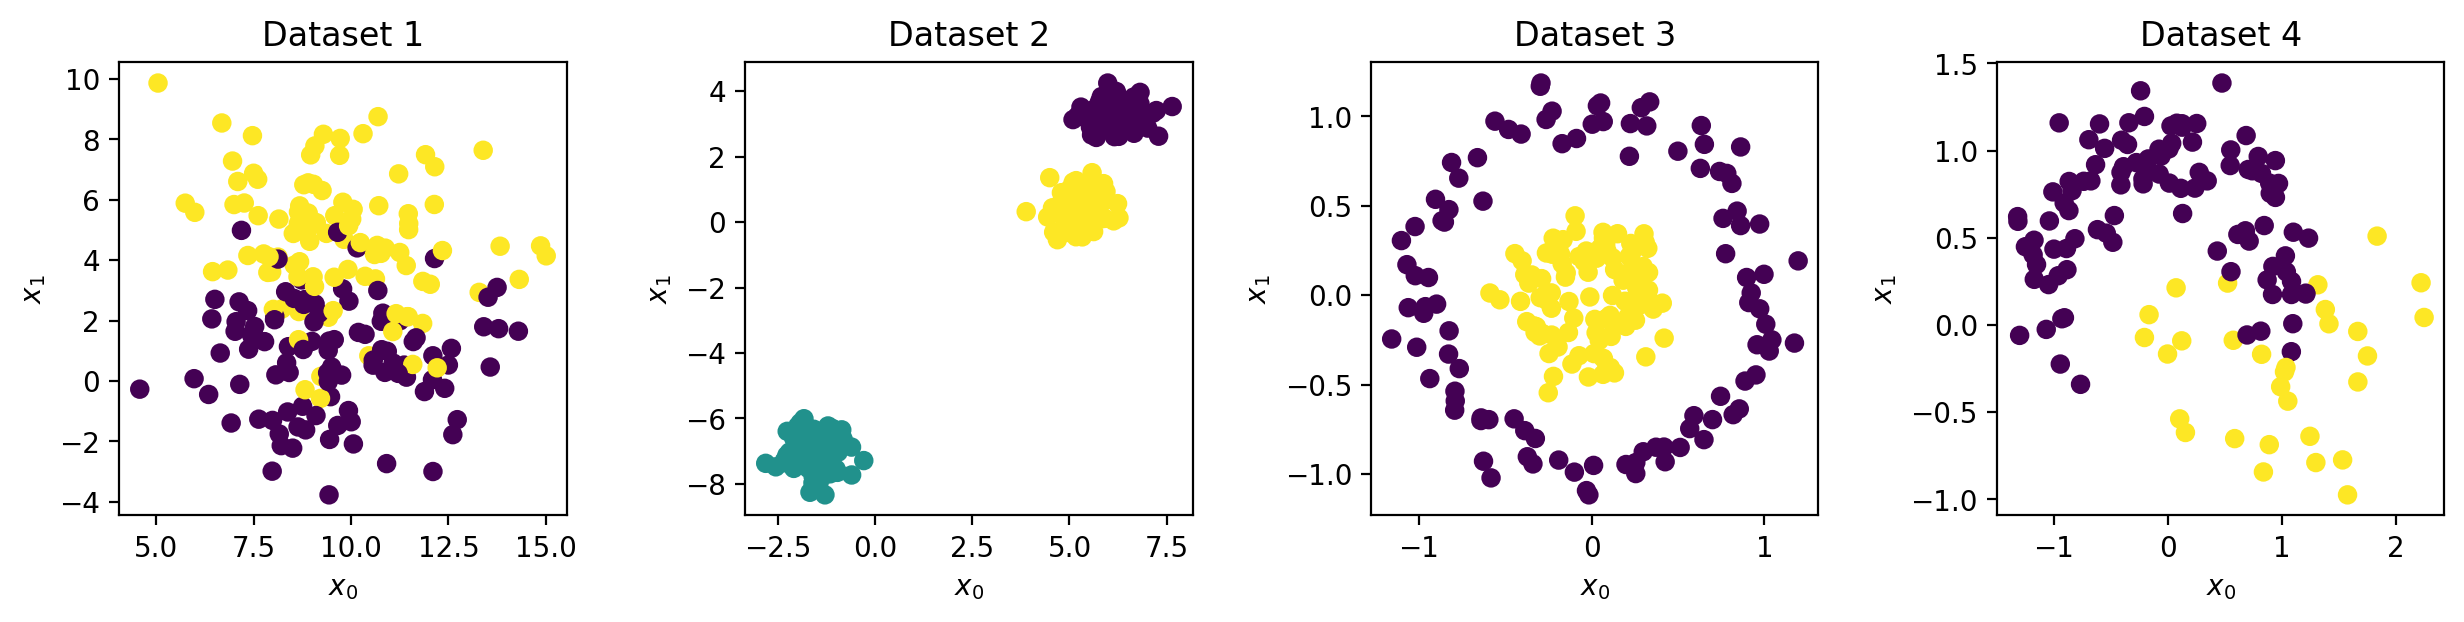

In [2]:
from sklearn.datasets import make_blobs, make_moons, make_circles
np.random.seed(4)

noisiness = 1

X_blob, y_blob = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

X_mc, y_mc = make_blobs(n_samples = 200, centers = 3, cluster_std = 0.5 * noisiness, n_features = 2)

X_circles, y_circles = make_circles(n_samples = 200, factor = 0.3, noise = 0.1 * noisiness)

X_moons, y_moons = make_moons(n_samples = 200, noise = 0.25 * noisiness)

N_include = 30
idxs = []
Ni = 0
for i, yi in enumerate(y_moons):
    if yi == 1 and Ni < N_include:
        idxs.append(i)
        Ni += 1
    elif yi == 0:
        idxs.append(i)

y_moons = y_moons[idxs]
X_moons = X_moons[idxs]

fig, axes = plt.subplots(1, 4, figsize = (15, 3), dpi = 200)

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]

labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:, 0], Xi[:, 1], c = yi)
    axes[i].set_title(labels[i])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')

fig.subplots_adjust(wspace = 0.4);

## 1. Discrimination Lines

**Derive the equation for the line that discriminates between the two classes.**

Consider a model of the form:

$\bar{\bar{X}}\vec{w} > 0$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} < 0$ if $y_i=-1$ (class 2)

where $\bar{\bar{X}} = [\vec{x_0}, \vec{x_1}, \vec{1}]$ and $\vec{w} = [w_0, w_1, w_2]$.

The equation should be in the form of $x_1 = f(x_0)$. Show your work, and/or explain the process you used to arrive at the answer.

**Ans:** 
 The equation will be
 
> $\bar{\bar{X}}\vec{w} = \vec{x_0}w_0 + \vec{x_1}w_1 + \vec{1}w_2 = 0$

> $x_1 = -\frac{w_0}{w_1}x_0 - \frac{w_2}{w_1}$

The slope will be $-\frac{w_0}{w_1}$ and the intercept will be $-\frac{w_2}{w_1}$

**Derive the discrimination line for a related non-linear model**

In this case, consider a model defined by:

$y_i = w_0 x_0 + w_1 x_1 + w_2 (x_0^2 + x_1^2)$

where the model predicts class 1 if $y_i > 0$ and predicts class 2 if $y_i \leq 0$.

The equation should be in the form of $x_1 = f(x_0)$. Show your work, and/or explain the process you used to arrive at the answer.

**Ans:** The equation will be 

> $w_0x_0 + w_1x_1 + w_2(x_0^2 + x_1^2)  =  0$

> $x_1^2 + \frac{w_1}{w_2}x_1  =  -\frac{w_0}{w_2}x_0 - x_0^2$

> $(x_1 + \frac{w_1}{2w_2})^2 + (x_0 + \frac{w_0}{2w_2})^2  =  (\frac{w_1}{2w_2})^2 + (\frac{w_0}{2w_2})^2$

> $x_1 = \sqrt{(-\frac{w_0}{w_2}x_0 - x_0^2 + (\frac{w_1}{2w_2})^2)} - (\frac{w_1}{2w_2})$

**Briefly describe the nature of this boundary.**

What is the shape of the boundary? Is it linear or non-linear?

**Ans:** According to

> $(x_1 + \frac{w_1}{2w_2})^2 + (x_0 + \frac{w_0}{2w_2})^2  =  (\frac{w_1}{2w_2})^2 - (\frac{w_0}{2w_2})^2$

The shape of boundary should be a circle. Therefore, it is non-linear

## 2. Assessing Loss Functions

In [3]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    X_intercept = np.append(intercept, X, 1)
    return X_intercept

In [4]:
def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return p > 0

**Write a function that computes the loss function for the perceptron model.**

The function should take the followings as arguments:
- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$

You may want to use functions above.

In [5]:
def perceptron(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    loss = sum(np.maximum(0, -y*Xb))
    return loss

**Write a function that computes the loss function for the logistic regression model.**

The function should take the followings as arguments:
- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$

You may want to use functions above.

In [6]:
def log_reg(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    loss = sum(np.log(1 + exp_yXb))
    return loss

**Minimize the both loss functions using the Dataset 3 above.**

In [25]:
from scipy.optimize import minimize
w = np.array([-9, -4, -9])

X = X_circles
y = y_circles * 2 - 1

result_perceptron = minimize(perceptron, w, args = (X, y))
result_logistic = minimize(log_reg, w, args = (X, y))

**What is the value of the loss function for the perceptron model after optimization?**

In [26]:
print(f'Perceptron loss function: {perceptron(result_perceptron.x, X, y)}')

Perceptron loss function: 7.43592526079778e-09


**What is the value of the loss function for the logistic regression model after optimization?**

In [27]:
print(f'Logistic regression loss function: {log_reg(result_logistic.x, X, y)}')

Logistic regression loss function: 138.60070170524114


**What are the two main challenges of the perceptron loss function?**

**Ans:**  
 1. The perceptron loss function has a trivial solution at $\vec{w}$ = 0
 2. The perceptron loss function is not differentiable

## 3. Support Vector Machine

**Write a function that computes the loss function of the support vector machine model.**

This functions should take the followings as arguments:

- weight vector $w$
- the feature matrix $\bar{\bar{X}}$
- the output vector $\vec{y}$
- regularization strength $\alpha$

You may want to use `add_intercept` and `linear_classifier` functions from the Problem 2.

In [10]:
def svm(w, X, y, alpha=1):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    loss = sum(np.maximum(0, 1 - y*Xb))
    loss += alpha*np.linalg.norm(w[1:], 2)
    return loss

**Evaluate the effect of regularization strength.**

Optimize the SVM model for **Dataset 1**.

Search over $\alpha$ = [0, 1, 2, 10, 100] and assess the loss function of the SVM model.

In [11]:
from scipy.optimize import minimize

X = X_blob
y = y_blob*2 - 1
w_guess = np.array([-10, -4, -10])

alphas = np.array([0, 1, 2, 10, 100])
results = []

for alpha in alphas:
    result = minimize(svm, w_guess, args=(X,y,alpha))
    results.append(result)
    print(svm(w_guess, X, y, alpha))

9627.260031082556
9638.030360696825
9648.800690311095
9734.963327225247
10704.292992509458


**Plot the discrimination lines for $\alpha$ = [0, 1, 2, 10, 100].**

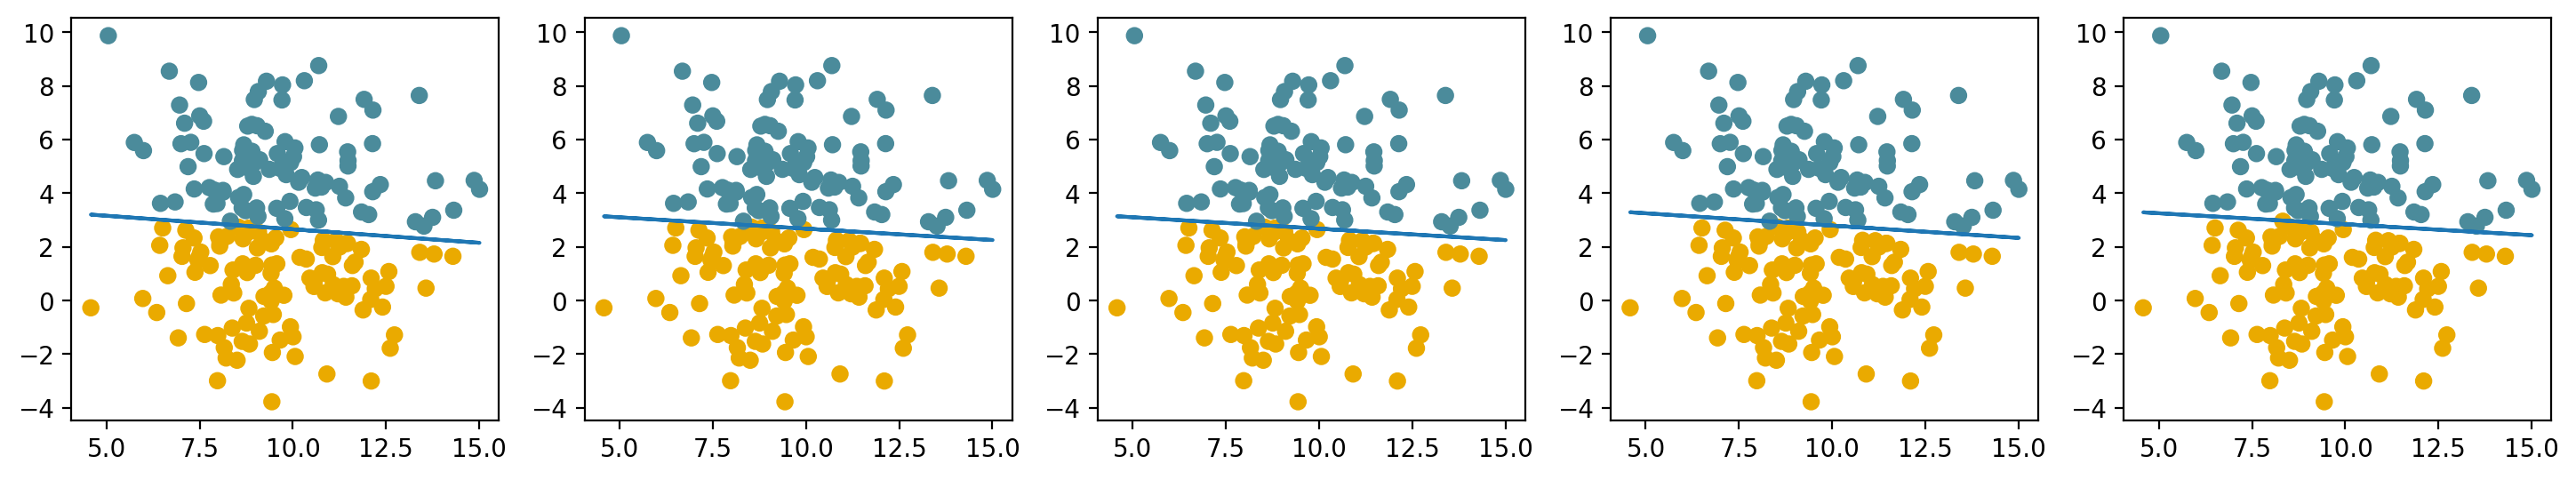

In [12]:
fig, axes = plt.subplots(1, 5, figsize = (18, 3), dpi = 200)

for i, result in enumerate(results):
    w_svm = result.x
    prediction = linear_classifier(X, w_svm)
    
    axes[i].scatter(X[:,0], X[:, 1], c=clrs[prediction + 1])
    m = -w_svm[1] / w_svm[2]
    b = -w_svm[0] / w_svm[2]
    axes[i].plot(X[:, 0], m*X[:, 0] + b, ls = '-')

**Find the optimal set of hyperparameters for an SVM model with Dataset 1.**

Use `GridSearchCV` and find the optimal value of $\alpha$ and $\gamma$.

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])
gammas = 1./(2*sigmas**2)
alphas = np.array([1, 2, 10, 100])
Cs = 1./alphas
parameter_ranges = {'C': Cs, 'gamma':gammas}

svc = SVC(kernel = 'rbf')
SVC_search = GridSearchCV(svc, parameter_ranges)
SVC_search.fit(X, y_blob)
print(f"Optimal Alpha: {1./SVC_search.best_estimator_.C}")
print(f"Optimal gamma: {SVC_search.best_estimator_.gamma}")
print(f"r2 Best Score: {SVC_search.best_score_}")

Optimal Alpha: 2.0
Optimal gamma: 0.0005555555555555556
r2 Best Score: 0.8699999999999999


**Calculate the accruacy, precision, and recall for the best model.**

You can write your own function that calculates the metrics or you may use built-in functions.

In [14]:
def acc_prec_recall(y_model, y_actual):
    TP = np.sum(np.logical_and(y_model == y_actual, y_model == 1))
    TN = np.sum(np.logical_and(y_model == y_actual, y_model == 0))
    FP = np.sum(np.logical_and(y_model != y_actual, y_model == 1))
    FN = np.sum(np.logical_and(y_model != y_actual, y_model == 0))
    acc = (TP + TN) / (TP + TN + FP + FN)
    if TP == 0:
        prec = 0
        recall = 0
    else:
        prec = TP / (TP + FP)
        recall = TP / (TP + FN)
    return acc, prec, recall

In [15]:
from sklearn.metrics import confusion_matrix

svc_model = SVC(kernel='rbf', gamma=SVC_search.best_estimator_.gamma, C=SVC_search.best_estimator_.C)
svc_model.fit(X_blob, y_blob)
y_model = svc_model.predict(X_blob)

acc, prec, recall = acc_prec_recall(y_model, y_blob)
print(f"From acc_prec_recall function => accuracy: {acc} precision: {prec} recall: {recall}")

From acc_prec_recall function => accuracy: 0.86 precision: 0.8829787234042553 recall: 0.83


**Plot the confusion matrix.**

[[89 11]
 [17 83]]


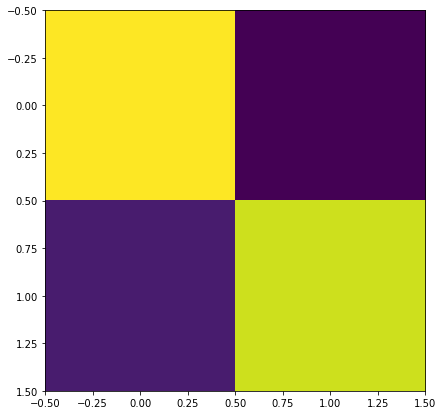

In [16]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_blob, y_model)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(conf_mat, cmap = 'viridis');
print(conf_mat)

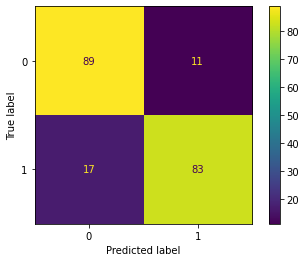

In [18]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svc_model, X_blob, y_blob)

**What happens to the decision boundary as $\alpha$ goes to $\infty$?**

**Ans:**  
 When $\alpha$ goes to $\infty$, C goes to 0. It will also mean that the regulization strength is high, resulting in large margins

**What happens to the decision boundary as $\gamma$ goes to 0?**

**Ans:**  
 When $\gamma$ goes to 0, it will result in wide rbf kernel

## 4. 6745 Only: Analytical Derivation

**Derive an analytical expression for the gradient of the softmax function with respect to $\vec{w}$.**

The **softmax** loss function is defined as:

$g(\vec{w}) = \sum_i log(1 + \exp{(-y_i \vec{x}_i^T \vec{w}}))$

where $\vec{x}_i$ is the $i$-th row of the input matrix $\bar{\bar{X}}$.

*Hint 1: The function $g(\vec{w})$ can be expressed as $f(r(s(\vec{w})))$ where $r$ and $s$ are arbitrary functions and the chain rule can be applied.*

*Hint 2: You may want to review Ch. 4 of "Machine Learning Refined, 1st Ed."*

> $g(\vec{w}) = \sum_i log(1 + \exp{(-y_i \vec{x}_i^T \vec{w}}))$

> $\sigma(-t) = \frac{1}{1 + e^t}$, $-t = -y_i \vec{x}_i^T \vec{w}$ 

> $\nabla{g(\vec{w})} = -\sum_i\sigma(-y_i \vec{x}_i^T \vec{w})y_i \vec{x}_i$

> $\nabla{}^2{g(\vec{w})} = -\sum_i\sigma(-y_i \vec{x}_i^T \vec{w})(1-\sigma( -y_i \vec{x}_i^T \vec{w}))\vec{x}_i\vec{x}_i^T$

**Optional: Logistic regression from the regression perspective**

An alternate interpretation of classification is that we are performing non-linear regression to fit a **step function** to our data (because the output is whether 0 or 1). Since step functions are not differentiable at the step, a smooth approximation with non-zero derivatives must be used. One such approximation is the *tanh* function:

$\tanh{(x)} = \frac{2}{1 + \exp{(-x)}} - 1$

This leads to a reformulation of the classification problem as:

$\vec{y} = \tanh{(\bar{\bar{X}}\vec{w})}$

Show that this is mathematically equivalent to **logistic regression**, or minimization of the **softmax** cost function.

# Classification - Assignment 7

## Data and Package Import

In [273]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

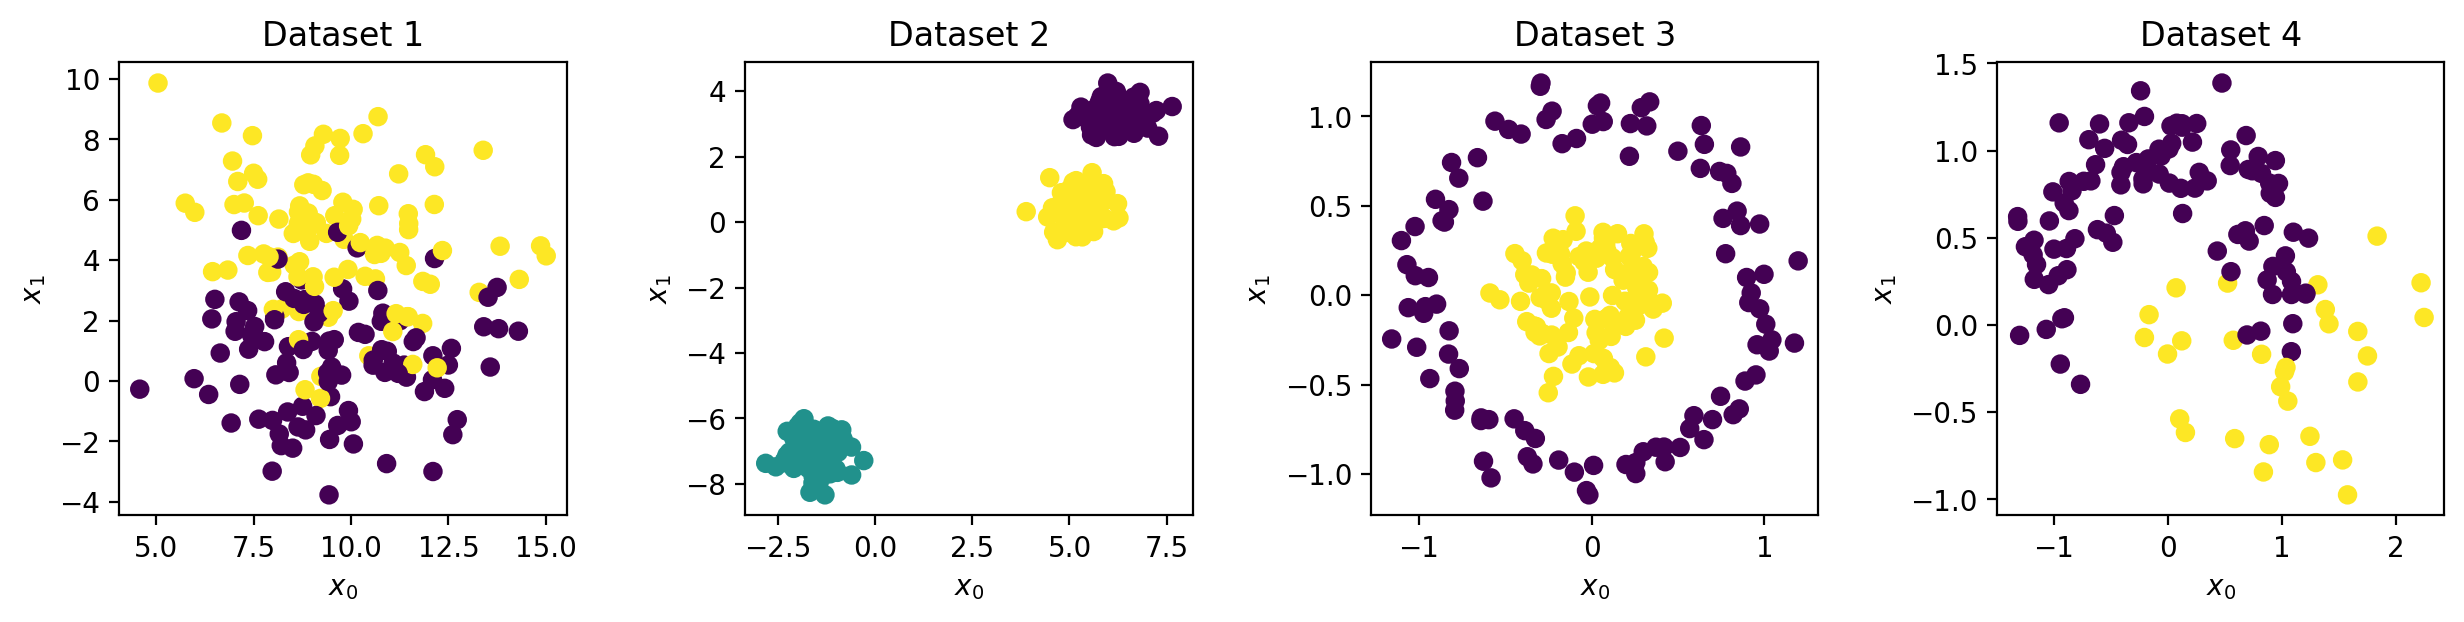

In [274]:
from sklearn.datasets import make_blobs, make_moons, make_circles
np.random.seed(4)

noisiness = 1

X_blob, y_blob = make_blobs(n_samples = 200, centers = 2, cluster_std = 2 * noisiness, n_features = 2)

X_mc, y_mc = make_blobs(n_samples = 200, centers = 3, cluster_std = 0.5 * noisiness, n_features = 2)

X_circles, y_circles = make_circles(n_samples = 200, factor = 0.3, noise = 0.1 * noisiness)

X_moons, y_moons = make_moons(n_samples = 200, noise = 0.25 * noisiness)

N_include = 30
idxs = []
Ni = 0
for i, yi in enumerate(y_moons):
    if yi == 1 and Ni < N_include:
        idxs.append(i)
        Ni += 1
    elif yi == 0:
        idxs.append(i)

y_moons = y_moons[idxs]
X_moons = X_moons[idxs]

fig, axes = plt.subplots(1, 4, figsize = (15, 3), dpi = 200)

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]

labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']
for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:, 0], Xi[:, 1], c = yi)
    axes[i].set_title(labels[i])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')

fig.subplots_adjust(wspace = 0.4);

In [275]:
df = pd.read_csv('data/perovskite_data.csv')
X_perov = df[['nA', 'nB', 'nX', 'rA (Ang)', 'rB (Ang)', 'rX (Ang)', 't', 'tau']].values
y_perov = df['exp_label'].values

## 1. k-nearest Neighbors Model

### 1-NN
**Calculate the accuracy of a 1-nearest Neighbors model for the training data.**

A 1-nearest Neighbors model considers a point as its own nearest neighbors.

*Hint: the block below is not a code block.*

**Ans:**  
 The accuracy would be 1, which means 100%. The point is just determining the class with its own input.

**Will this be a reliable indicator of its accuracy for testing data?**

Briefly explain your answer.

**Ans:**  
 No, it will not be. The 1-NN model won't really be reliable simply because it isn't really implementing the voting and the democracy of the kNN model.

### Weighted Neighbors Classification

Instead of selecting the k-nearest neighbors to vote, we could design an algorithm where all neigbors get to vote, but their vote is weighted inversely to their distance from the point of interest:

$y_i = \sum_j y_j/(||x_i - x_j||)$

where $j$ is an index over all training points.

The class will be assigned as follows:

- class 1 if $y_i \geq 0$

- class -1 if $y_i < 0$

In [276]:
def distance(x1, x2):
    return np.linalg.norm(x1 - x2, 2)

In [277]:
def get_neighbor(x, x_list):
    dist_pairs = []
    for i, xi in enumerate(x_list):
        dist = distance(x, xi)
        dist_pairs.append([dist, i])
    return dist_pairs

**Write a function that assigns a class to a point.**

The function should take the followings as arguments:
- a single point `x`
- a list of training points `x_list`
- a list of training labels `y_list`

You may want to use functions above. You will also need to add a statement to avoid dividing by zero if the point is in the training set. If the distance between 2 points is zero, then the label from the same point in the training set should be used (e.g. if $x_i = x_j$ then $y_i = y_j$).

In [278]:
def assign_class(x, x_list, y_list):
    dist_pairs = get_neighbor(x, x_list)
    y_list = list(y_list)
    sum = 0
    for dist, i in dist_pairs:
        if dist == 0:
            sum += y_list[i]/1e-12
        else:
            sum += y_list[i]/dist
    if (sum >= 0):
        assignment = 1
    else:
        assignment = -1
    
    return assignment

**Write a function that returns the prediction for a given list of testing points.**

The function should take the followings as arguments:
- a list of testing points `X`
- a list of training points `X_train`
- a list of training labels `y_train`

In [279]:
def weighted_neighbors(X, X_train, y_train):
    y_out = []
    for xi in X:
        y_out.append(assign_class(xi, X_train, y_train))
    y_out = np.array(y_out)
    return y_out

**Train the model for the perovskite dataset using a random selection of 75% of the data as training data.**

In [280]:
df = pd.read_csv('data/perovskite_data.csv')

feature_columns = ['nA', 'nB', 'nX', 'rA (Ang)', 'rB (Ang)', 'rX (Ang)', 't', 'tau']

X_perov = df[feature_columns].values
y_perov = df['exp_label'].values

print(f"X_perov: {X_perov.shape} y_perov: {y_perov.shape}")

df.head(5)

X_perov: (576, 8) y_perov: (576,)


,ABX3,A,B,X,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang),t,tau,exp_label
0,AgBiO3,Ag,Bi,O,1,5,-2,1.28,0.76,1.40,0.88,4.07,-1
1,AgBrO3,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1
2,AgCaCl3,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1
3,AgCdBr3,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1
4,AgClO3,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1


In [281]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size=0.25)

y_wn = weighted_neighbors(X_test, X_train, y_train)

**Compute the accuracy and precision of the prediction.**

In [282]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_wn).ravel()
acc = (tp + tn)/(tp + tn + fp + fn)
prec = tp/(tp + fp)

print(f"Weighted Neighbor => Accuracy: {acc} Precision: {prec}")

Weighted Neighbor => Accuracy: 0.8680555555555556 Precision: 0.8297872340425532


**Train a 5-NN model using the same training data.**

In [283]:
from sklearn.neighbors import KNeighborsClassifier

kNN_5 = KNeighborsClassifier(n_neighbors=5)
kNN_5.fit(X_train, y_train)
y_kn5 = kNN_5.predict(X_test)

**Compute the accuracy and precision.**

In [284]:
from sklearn.metrics import accuracy_score, precision_score

acc = accuracy_score(y_test, y_kn5)
prec = precision_score(y_test, y_kn5)
print(f"5-NN => Accuracy: {acc} Precision: {prec}")

5-NN => Accuracy: 0.9027777777777778 Precision: 0.9135802469135802


## 2. Multi-dimensional Classification

### Simple logistic regression
**Train a logistic regression model using all columns except the `tau` column of the perovskite dataset.**

You may use some functions that have been already built in the previous assignments.

In [285]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
logreg = LogisticRegression()

In [286]:
X_no_tau = X_perov[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X_no_tau, y_perov)

logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(f"Training score: {logreg.score(X_train, y_train)}")

Training score: 0.8078703703703703


**Plot the confusion matrix.**

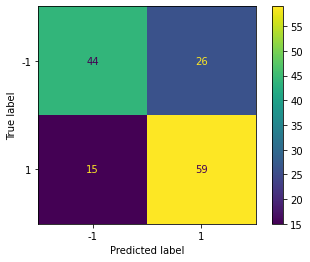

In [287]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_test, y_test)

**Compute the accuracy, precision and recall.**

In [288]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log).ravel()
acc = (tp + tn)/(tp + tn + fp + fn)
prec = tp/(tp + fp)
recall = tp/(tp + fn)
print(f"Accuracy: {acc} Precision: {prec} Recall: {recall}")

Accuracy: 0.7152777777777778 Precision: 0.6941176470588235 Recall: 0.7972972972972973


### 6745 Only: Customizing non-linear boundaries

In this problem, you will create a single custom feature that improves the separation performance as much as possible.

**Plot the `y_perov` as a function of `rA (Ang)` and `rB (Ang)`.**

In [289]:
df = pd.read_csv('data/perovskite_data.csv')
feature_columns = ['nA', 'nB', 'nX', 'rA (Ang)', 'rB (Ang)', 'rX (Ang)', 't', 'tau']

X_perov = df[feature_columns].values
y_perov = df['exp_label'].values

print(X_perov.shape, y_perov.shape)

(576, 8) (576,)


Text(0, 0.5, 'rB (Ang)')

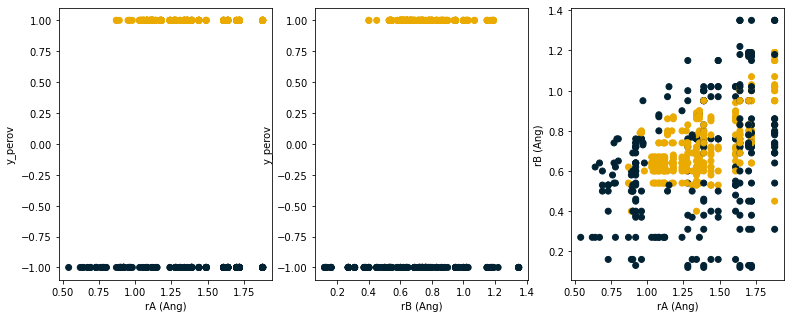

In [290]:
fig, axes = plt.subplots(1, 3, figsize = (13, 5))

axes[0].scatter(X_perov[:,3], y_perov, c = clrs[y_perov])
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel("y_perov")

axes[1].scatter(X_perov[:,4], y_perov, c = clrs[y_perov])
axes[1].set_xlabel(feature_columns[4])
axes[1].set_ylabel("y_perov")

axes[2].scatter(X_perov[:,3], X_perov[:,4], c = clrs[y_perov])
axes[2].set_xlabel("rA (Ang)")
axes[2].set_ylabel("rB (Ang)")

**Build a baseline model based on logistic regression.**

Report the accuracy and precision of the baseline model.

In [291]:
def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return np.array(p > 0, dtype = int)

def softmax_cost(w, X, y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    return sum(np.log(1 + exp_yXb))

In [292]:
from scipy.optimize import minimize
w_guess = np.array([-10, -4, -10])
result = minimize(softmax_cost, w_guess, args = (X_perov[:,3:5], y_perov))
w_logit = result.x

prediction = linear_classifier(X_perov[:,3:5], w_logit)
y_prediction = [1 if i else -1 for i in prediction]

print(f"Accuracy: {accuracy_score(y_perov, y_prediction)}")
print(f"Precision: {precision_score(y_perov, y_prediction)}")

Accuracy: 0.6631944444444444
Precision: 0.6263269639065817


**Plot the prediction of the baseline model.**

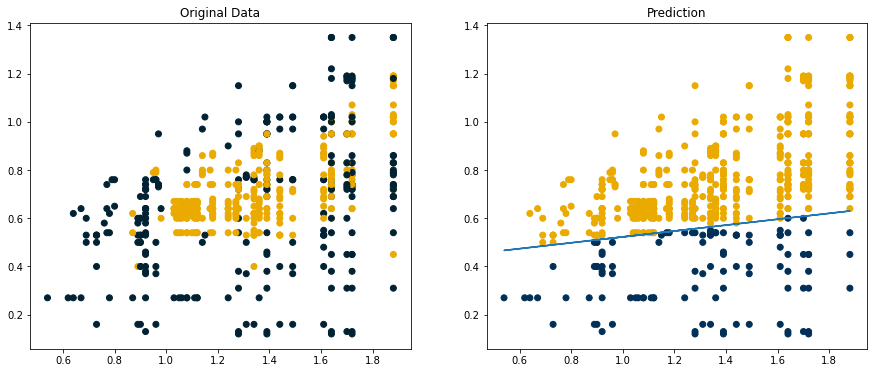

In [293]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov])
axes[1].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[prediction])

#plot line
m = -w_logit[1] / w_logit[2]
b = -w_logit[0] / w_logit[2]
axes[1].plot(X_perov[:, 3], m*X_perov[:, 3] + b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

**Create a new feature based on a non-linear combination of `rA (Ang)` and `rB (Ang)`.**

Plot the new feature as a function of `rA (Ang)`.

(576, 3)


Text(0, 0.5, 'non-linear combination of rA & rB')

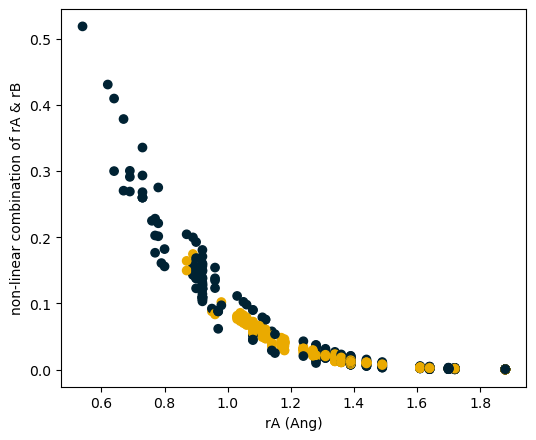

In [294]:
X = X_perov[:,3:5]
y = y_perov

X_new = np.exp(-(2*X[:,0]**2 + X[:,1]**2))
X_new = X_new.reshape(-1, 1)
X_nonlinear = np.append(X, X_new, 1)
print(X_nonlinear.shape)

fig, ax = plt.subplots(figsize=(6,5), dpi=100)
ax.scatter(X_nonlinear[:,0], X_nonlinear[:,2], c=clrs[y])
ax.set_xlabel('rA (Ang)')
ax.set_ylabel('non-linear combination of rA & rB')

**Build a new model that includes `rA (Ang)`, `rB (Ang)` and your new feature.**

Report the accuracy and precision.

In [295]:
new_logreg = LogisticRegression()
new_logreg.fit(X_nonlinear, y)
y_new_predict = new_logreg.predict(X_nonlinear)

print(f"New Model Accuracy: {accuracy_score(y, y_new_predict)}")
print(f"New Model Precision: {precision_score(y, y_new_predict)}")

New Model Accuracy: 0.7100694444444444
New Model Precision: 0.6546610169491526


**Plot the result of your new model.**

Text(0.5, 1.0, 'Prediction Data')

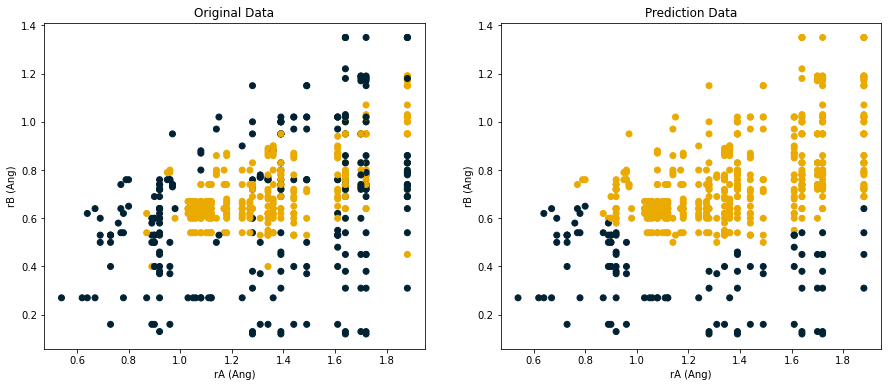

In [296]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(X[:,0], X[:,1], c = clrs[y])
axes[0].set_xlabel("rA (Ang)")
axes[0].set_ylabel("rB (Ang)")
axes[0].set_title("Original Data")

axes[1].scatter(X[:,0], X[:,1], c = clrs[y_new_predict])
axes[1].set_xlabel("rA (Ang)")
axes[1].set_ylabel("rB (Ang)")
axes[1].set_title("Prediction Data")

**Briefly explain how you decided on the feature.**

**Ans:**  
  By looking at the classification of the Original data, the data looks like it should have a decision boundary similiar to a circle and a Gaussian transform. After a few trial and error, the final new feature is based on rA and rB to form a ellipse with Gaussian transform to form a non-linear combination of rA and rB.
  $X_{nonlinear}$ = $exp(-(2*x_0^2 + x_1^2))$

## 3. Comparison of Classification Model

In this problem, you will compare the classification performance of three different models using the perovskite dataset.

**Choose three different classification models and import them.**

These could be models discussed in the lectures, or others that you have learned about elsewhere.

In [297]:
# Decision Tree model
from sklearn.tree import DecisionTreeClassifier
# kNN model
from sklearn.neighbors import KNeighborsClassifier
# SVM model
from sklearn.svm import SVC

In [298]:
dtree = DecisionTreeClassifier() 
kNN = KNeighborsClassifier()
svc = SVC(kernel = 'rbf')

**Make a hyperparameter grid for each model.**

You should optimize at least one hyperparameter for each model.

In [299]:
from sklearn.model_selection import GridSearchCV

sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas

n_neighborss = np.array([2,4,6,8,10,12,15,20])

max_depths = np.array([4,5,6,7,8,9,10,20,30,40,50])

In [300]:
dtree_params = {'max_depth':max_depths}
dtree_search = GridSearchCV(dtree, dtree_params)

kNN_params = {'n_neighbors':n_neighborss}
kNN_search = GridSearchCV(kNN, kNN_params)

svc_params = {'C': Cs, 'gamma': gammas}
svc_search = GridSearchCV(svc, svc_params)

**Optimize hyperparameters.**

First, you select a validation set using hold-out (`train_test_split`). Optimize hyperparameters using `GridSearchCV` on the training set.

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size=0.33)

dtree_search.fit(X_train, y_train)
print(f"Decision Tree: estimator = {dtree_search.best_estimator_} score = {dtree_search.best_score_}")

kNN_search.fit(X_train, y_train)
print(f"KNN: estimator = {kNN_search.best_estimator_} score = {kNN_search.best_score_}")

svc_search.fit(X_train, y_train)
print(f"SVC: estimator = {svc_search.best_estimator_} score = {svc_search.best_score_}")

Decision Tree: estimator = DecisionTreeClassifier(max_depth=4) score = 0.909090909090909
KNN: estimator = KNeighborsClassifier(n_neighbors=4) score = 0.9064935064935066
SVC: estimator = SVC(C=1000.0, gamma=0.005) score = 0.9194805194805195


**Compare the accuracy by predicting the results of the validation set.**

In [302]:
dtree_best = DecisionTreeClassifier(max_depth=9)
dtree_best.fit(X_train, y_train)
y_dtree = dtree_best.predict(X_test)
print(f"Decision Tree: accuracy = {accuracy_score(y_test, y_dtree)} precision = {precision_score(y_test, y_dtree)}")

kNN_best = KNeighborsClassifier(n_neighbors=8)
kNN_best.fit(X_train, y_train)
y_kNN = kNN_best.predict(X_test)
print(f"KNN: accuracy = {accuracy_score(y_test, y_kNN)} precision = {precision_score(y_test, y_kNN)}")

svc_best = SVC(kernel='rbf', gamma=0.5, C=10)
svc_best.fit(X_train, y_train)
y_svc = svc_best.predict(X_test)
print(f"SVC: accuracy = {accuracy_score(y_test, y_svc)} precision = {precision_score(y_test, y_svc)}")

Decision Tree: accuracy = 0.900523560209424 precision = 0.9504950495049505
KNN: accuracy = 0.9319371727748691 precision = 0.944954128440367
SVC: accuracy = 0.9424083769633508 precision = 0.9380530973451328


**Briefly describe your conclusions based on the results.**

**Ans:**  
 As a result, the KNN model has the highest score. However, the score of the KNN is not significantly higher than the scores of SVC and Decision Tree models. The slight difference of the results is due to the random and the train test split. The three models are all good for highly non-linear class boundaries.